# Imports

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

import pandas as pd

# from matplotlib.colors import Lognorm
from scipy.integrate import simps
from time import time
import warnings
warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


In [3]:
from ipywidgets import interact
import seaborn as sns
sns.set(palette='colorblind', style='whitegrid')
sns.set_style({'font.family': ['serif']})
from matplotlib.colors import LogNorm, SymLogNorm

In [4]:
from scipy.optimize import minimize
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import interp1d
from scipy import stats
from sklearn.metrics.pairwise import pairwise_kernels

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
RBF = kernels.RBF
WhiteKernel = kernels.WhiteKernel

In [5]:
sys.path.append('../cf_analysis/')
import tools

import glearn
from rscm import RSCM
# from cf_analysis import pcalearn
from sklearn.decomposition import PCA
from svdanalysis import SVDlearn
import synth, kde, pcalearn
from pcalearn import PCAYJ

# from cf_analysis import kde
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.base import BaseEstimator, RegressorMixin
KernelRegression = kde.KernelRegression

import yjtransform as yjt


# Setup

In [6]:

class GetObject(object):
    def __init__(self, *initial_data, **kwargs):
        for dictionary in initial_data:
            for key in dictionary:
                setattr(self, key, dictionary[key])
        for key in kwargs:
            setattr(self, key, kwargs[key])           
            
    

In [7]:
# data = pd.read_csv('../The_Tax_Burden_on_Tobacco__1970-2017.csv')
# data = data[data['Year'] <=2005]
# years = data['Year'].unique()
# # Tf = years[years <=2005]
# sales = data[data['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']
# costs = data[data['SubMeasureDesc'] == 'Average Cost per pack ']    

# statesid = data['LocationAbbr'].unique()
# statesales, statecosts = {}, {}
# for ss in statesid:
#     statesales[ss] = sales[sales['LocationAbbr'] == ss]['Data_Value'].values.astype('float64')
#     statecosts[ss] = costs[costs['LocationAbbr'] == ss]['Data_Value'].values.astype('float64')
# sskip = ['CA', 'MA', 'AZ', 'OR', 'FL', 'AL', "HI", 'MD', 'MI','NJ', 'NY', 'WA', 'DC']
# taxstates = ['CA', 'MA', 'OR', 'FL', 'AZ']
# controlstates = list(set(statesid) - set(sskip))


# controls = np.array([statesales[ss] for ss in statesid if ss!= 'CA'])
# # controls = np.array([statesales[ss] for ss in controlstates if ss!= 'CA'])
# treated = statesales['CA']

# X = controls.copy()

# # ncd = 5
# # # Xraw = np.array([statesales[i] for i in statesales.keys()])
# # Xraw = np.array([statesales[i] for i in controlstates])
# # Xrawmean = Xraw.mean(axis=0)
# # Xraw -= Xrawmean
# # pcad = PCA(ncd).fit(Xraw)
# # X = pcad.inverse_transform(pcad.transform(Xraw))

# N, T = X.shape[0], X.shape[1]
# T0 = 18
# itreated = 4
# t = np.arange(T)

In [13]:


# years = t           

data = pd.read_csv('../basque.csv')
years = data['year'].unique()
xplot = years.copy()            
T0 = np.where(years == 1970)[0][0]
years = years[:2*T0]
gdp = data['gdpcap'].values.reshape(18, -1)
gdp = gdp[1:, :2*T0]
treated = gdp[-2]
rr = data['regionname'].unique()[-2]
controls = np.append(gdp[:-2], gdp[-1:], axis=0)

X = gdp.copy()
N, T = X.shape[0], X.shape[1]
t = np.arange(T)
itreated = 15
xplot = years.copy()

tools.approximate_rank(controls - controls.mean(axis=0), 0.999)

5

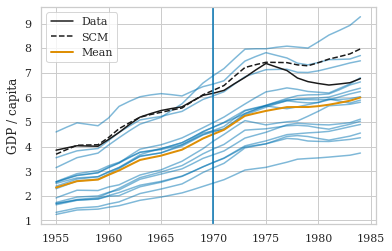

In [8]:
plt.plot(years, controls.T, 'C0', alpha=0.5)
plt.plot(years, treated, 'k', label='Data')
plt.plot(years, synth.fit(controls, treated, T0)[0],'k--', label='SCM')
plt.plot(years, controls.mean(axis=0), 'C1', lw=2, label='Mean')
# plt.plot(pcad.inverse_transform(pcad.transform((treated-Xrawmean).reshape(1, -1))).flatten()+Xrawmean)
# plt.plot(Xraw[4]+Xrawmean)
# plt.plot(X[4]+Xrawmean)
plt.ylabel('GDP / capita')
plt.axvline(years[T0])
plt.legend()
plt.show()



In [9]:
# T = 100
# ncd = 10
# t = np.arange(0, T)
# T0 = 60
# N = 50


# X = np.random.normal(10, 2, N*T).reshape(N, T)
# X = X + np.random.normal(0, N, N).reshape(-1, 1)
# X = X + np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1).reshape(-1, 1)*t/T
# X = X + np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)*t**2/T * np.exp(-2*t/T)
# # X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.pi/T* t* np.random.normal(size=N).reshape(-1, 1)) 
# X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.random.normal(0)*np.pi/T* t) 
# X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.random.normal(1)*np.pi/T* t) 
# X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.random.normal(2)*np.pi/T* t) 

# X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.random.normal(3)*np.pi/T* t) 
# X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.random.normal(4)*np.pi/T* t) 
# Xraw = X.copy()
# pcad = PCA(ncd).fit(Xraw)
# X = pcad.inverse_transform(pcad.transform(Xraw))

# itreated = np.random.randint(N)
# controls = np.concatenate([X[:itreated], X[itreated+1:]])
# treated = X[itreated]

# fig, ax = plt.subplots(1, 2, figsize = (8, 4))
# ax[0].plot(Xraw.T)
# ax[1].plot(controls.T, 'b', alpha=0.5)
# ax[1].plot(treated, 'r', alpha=1)
# plt.show()
# plt.plot(pcad.components_.T);
# plt.show()
# plt.plot(np.linalg.svd(Xraw)[1], 'o');
# plt.semilogy()
# plt.show()

# SCM

In [10]:

scmfits =  {}
for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ##
    ##
    X1 = (xx - means)[:, :T0]
    X2 = (xx - means)[:, T0:]
    Y1 = (yy-means)[:T0]
    Y2 = (yy-means)[T0:]
    yp, wts = synth.fit(xx, yy, T0)
        
    scmfits[ss] = GetObject(controls=xx, treated=yy, pred=yp, wts=wts)
    
    
    

scmfitsres =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    ##
    ##
    mmx, mmy = xxc[:, :T0].mean(axis=1), yyc[:T0].mean()
    xx = xxc - mmx.reshape(-1, 1)
    yy = yyc - mmy
    
    yp, wts = synth.fit(xx, yy, T0)    
    yp += mmy
    
    scmfitsres[ss] = GetObject(controls=xxc, treated=yyc, pred=yp, wts=wts)    

# Fourier Anlaysis

[]

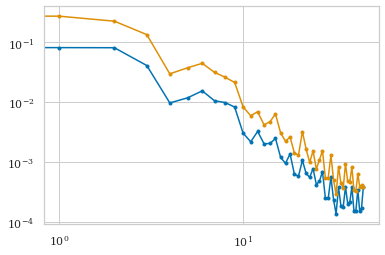

In [54]:
diff = controls[:, :T0].mean(axis=1).reshape(-1, 1)
difft = treated[:T0].mean()

gl = glearn.GLearn(controls-diff, padl=T, padr=T, stdscale=False, normalization=None)
# gl = glearn.GLearn(controls, padl=T//4, padr=T//4, stdscale=False, normalization='standard')
plt.plot(gl.pkraw, marker='.')
plt.plot(gl.pkprior, marker='.')
plt.loglog()

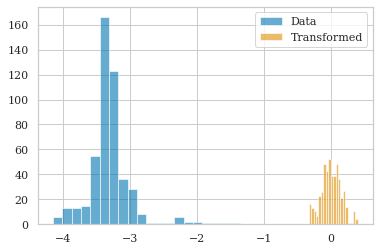

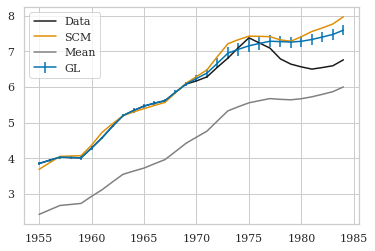

In [55]:
# glpred, glerr, glcov = gl.fit(treated, 15)
glpred, glerr, glcov = gl.fit(treated - difft, 15)
glpred += difft

bins = 20 
normed = False
# plt.hist((controls - means).flatten(), bins=bins, normed=normed, label='Data', alpha=0.6, color='C0')
plt.hist((gl.controls-means).flatten(), bins=bins, normed=normed, label='Data', alpha=0.6, color='C0')
plt.hist(gl.controlsg.flatten(), bins=bins, normed=normed, label='Transformed', alpha=0.6, color='C1')
plt.legend()
plt.show()
# plt.hist(gca.controls.flatten())
plt.plot(years, treated,  'k', label='Data')
plt.errorbar(years, glpred, glerr, label='GL')
plt.plot(years, synth.fit(controls, treated, T0)[0], label='SCM')
plt.plot(years, means,'gray', label='Mean')
plt.legend()

In [57]:

glfits =  {}
for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    diff, difft = xx[:, :T0].mean(axis=1).reshape(-1, 1), yy[:T0].mean()
    ##
    ##
    gl = glearn.GLearn(xx-diff, padl=T, padr=T, stdscale=False)
    yp, err, cov = gl.fit(yy-difft, T0)
    yp += difft
    glfits[ss] = GetObject(controls=xx, treated=yy, pred=yp, err=err, cov=cov)
    
    


scmfits 0.6521917750834337
scmfitsres 0.5954710305771115
pcafits99 0.6603781654729112


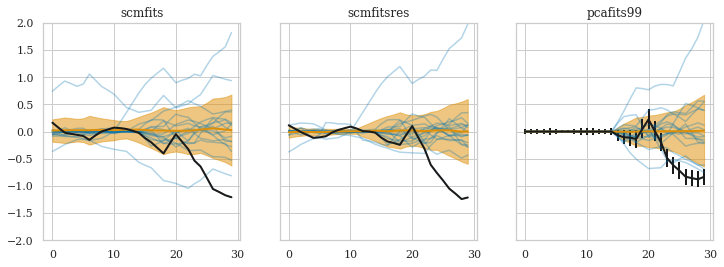

In [61]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])

titles = 'scmfits, scmfitsres, glfits'
titles = titles.split(', ')
for j, fits in enumerate([scmfits, scmfitsres, glfits]):
    tmp = []
    axis = ax.flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, mmean, 'C1', lw=2)
    try: axis.errorbar(xplot, tmp[itreated], fits[itreated].err, color='k', lw=2)
    except: axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
    axis.set_ylim(-2, 2)
#     axis.set_ylim(-50, 50)

#     axis.set_ylim(-50, 50)

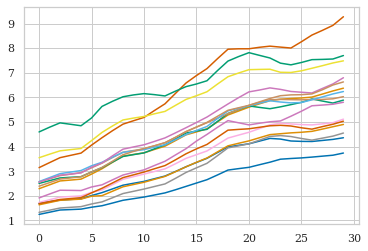

In [47]:
plt.plot(controls.T)

[]

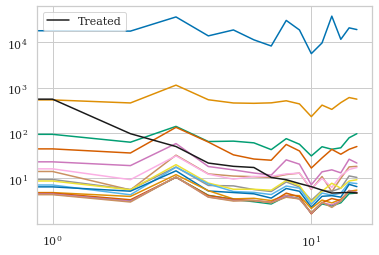

In [18]:
plt.plot(((np.fft.rfft(controls, axis=1).real**2) + np.fft.rfft(controls, axis=1).imag**2))
plt.plot(((np.fft.rfft(controls, axis=1).real**2) + np.fft.rfft(controls, axis=1).imag**2)[itreated], 'k', label='Treated')
plt.legend()
plt.loglog()

[]

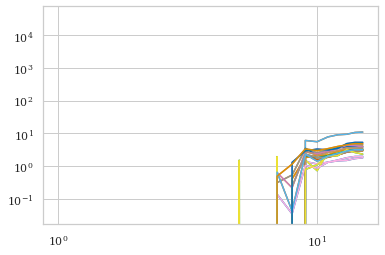

In [19]:
plt.plot((np.fft.rfft(controls, axis=1)**2).real.T);
plt.plot((np.fft.rfft(controls, axis=1)**2).real.T);
plt.loglog()

# PCA

In [53]:
xx = controls.copy()
means = xx.mean(axis=0)
yy = treated.copy()
xplot = np.arange(yy.size)
xx -= means
yy -= means
mmx = xx[: , :T0].mean(axis=1)
mmy = yy[:T0].mean()
xx -= mmx.reshape(-1, 1)
yy -= mmy
##
i = 0 
ncomp = tools.approximate_rank(xx-means , t=0.99)
# ncomp = tools.approximate_rank(xx - means, t=0.999)
# ncomp = 10
ncomp = 2
print(ncomp)
pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
pca = pcl.pca
errpca = pca.get_covariance().diagonal()**0.5


2


In [54]:
pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)

0.14162173605910142

<ErrorbarContainer object of 3 artists>

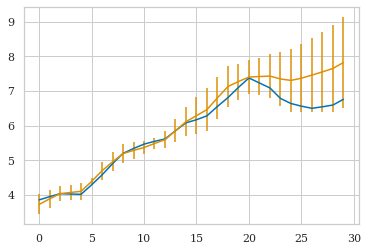

In [55]:

pclT0 = pcalearn.PCAlearn(xx[:, :T0], ncomp, stdscale=False, normalization='center')
pcaT0 = pclT0.pca

##
ypca, err,  pp = pcl.fitanalytic(yy.flatten(), T0, regwt=None, verbose=True)
ypca += means
ypca += mmy
plt.plot(xplot, treated, label='data')
plt.errorbar(xplot, ypca , err)
# plt.plot(xplot, yy + means, label='data')
# plt.plot(xplot, means, ':')
# plt.plot(xplot, ypcar, ":", lw=3, alpha=0.5)
# plt.plot(xplot, ypcar2, ':', lw=3, alpha=0.5)


In [56]:
pp

array([0.50229455, 1.17545769])

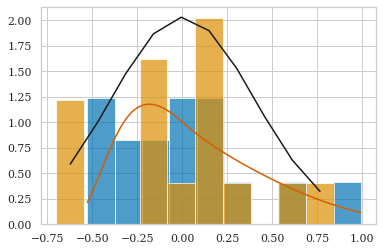

In [57]:
nbins=10
xxt = pca.transform(pcl.normalize(xx))
tt = xxt[:, 1].copy()
plt.hist(tt.flatten(), alpha=0.7, bins=nbins, density=True)
ptt = yjt.get_transform(tt)
# plt.plot(ttx, yjt.invtransform(ttx, ptt))
ttx = np.linspace(tt.min(), tt.max())
qq = yjt.getpdf(ttx, ptt)
plt.plot(ttx, qq, 'r')

y_, x_, _ = plt.hist(yjt.transform(tt,  ptt).flatten(), alpha=0.7, bins=nbins, density=True)
x_ = (x_[1:] + x_[:-1])/2.
pp = tools.fitgausspdf(yjt.transform(tt,  ptt).flatten(), normalized=True, verbose=0)    
plt.plot(x_, y_.max()*tools.logpdf_gauss(x_, *pp, rety=True), 'k')


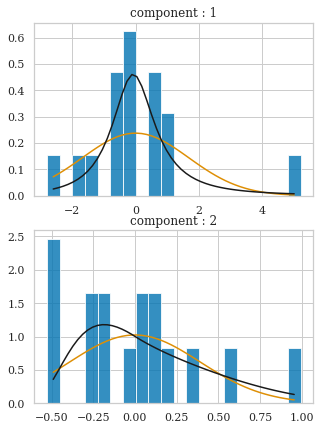

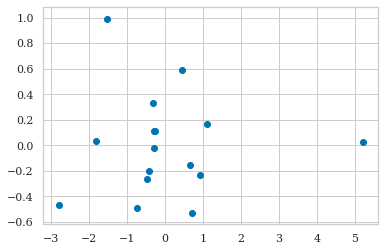

In [58]:
nbins = 20 
normed = True

# # ncomp = 10
# # xx = controls.copy()
# # pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
# # pca = pcl.pca
# xxt = pca.transform(pcl.normalize(xx))

fig, axar = plt.subplots(2, ncomp//2, figsize= (ncomp//2*5, 7))

ax = axar.flatten()
for ia in range(ncomp):
    if ia >= ax.size: break
    if ia > ncomp: break    
    y_, x_, _ = ax[ia].hist(xxt.T[ia], bins=nbins, density=normed, alpha=0.8)
    x_ = (x_[1:] + x_[:-1])/2.

    xplot = np.linspace(x_.min(), x_.max())
    ppg = tools.fitgausspdf(xxt.T[ia], normalized=True, verbose=0)    
    ax[ia].plot(xplot, tools.logpdf_gauss(xplot, *ppg, rety=True, normalized=True), 'C1')
    ax[ia].set_title("component : %d"%(ia+1))
    pyj = yjt.get_transform(xxt.T[ia])
    qq = yjt.getpdf(xplot, pyj)
    ax[ia].plot(xplot, qq, 'k')
    
plt.show()
plt.scatter(xxt[:, 0], xxt[:, 1])
plt.show()

In [60]:
# xxT0 = pcaT0.transform(pclT0.normalize(xx[:, :T0]))
# ppT0 = pcaT0.transform(pclT0.normalize(treated[:T0]).reshape(1, -1))[0]

# # fig, ax = plt.subplots(1, ncomp, figsize= (ncomp*4, 4))

# # ppT0 = pcaT0.transform(treated[:T0].reshape(np.newaxis, 1))

# fig, axar = plt.subplots(2, ncomp//2, figsize= (ncomp//2*4, 7))

# ax = axar.flatten()
# for ia in range(ncomp):
#     if ia >= ax.size: break
#     if ia > ncomp: break    
#     y_, x_, _ = ax[ia].hist(xxT0.T[ia], bins=nbins, density=normed, alpha=0.8)
#     x_ = (x_[1:] + x_[:-1])/2.

#     xplot = np.linspace(x_.min(), x_.max())
#     ppg = tools.fitgausspdf(xxT0.T[ia], normalized=True, verbose=0)    
#     ax[ia].plot(xplot, tools.logpdf_gauss(xplot, *ppg, rety=True, normalized=True), 'C1')
    
#     pyj = yjt.get_transform(xxT0.T[ia])
#     qq = yjt.getpdf(xplot, pyj)
#     ax[ia].plot(xplot, qq, 'k')
    
#     ax[ia].axvline(ppT0[ia], color='r', lw=2, ls="--")
#     ax[ia].set_title("component : %d"%(ia+1))

# plt.tight_layout()
# plt.show()

# fig, ax = plt.subplots(1, ncomp, figsize= (ncomp*4, 4))
# ax[0].scatter(xxT0[:, 0], xxT0[:, 1])
# ax[0].plot(ppT0[0], ppT0[1], 'rx', markersize=10, lw=2)
# ax[0].set_xlabel(0)
# ax[0].set_ylabel(1)

# ax[1].scatter(xxT0[:, 1], xxT0[:, 2])
# ax[1].plot(ppT0[1], ppT0[2], 'rx', markersize=10)
# ax[1].set_xlabel(1)
# ax[1].set_ylabel(2)

# ax[2].scatter(xxT0[:, 2], xxT0[:, 1])
# ax[2].plot(ppT0[2], ppT0[1], 'rx', markersize=10, lw=2)
# ax[2].set_ylabel(2)
# ax[2].set_xlabel(1)
# plt.tight_layout()
# plt.show()

In [10]:
pcafits95 = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.95)
    if not ii: print(ncpca)
    if ncpca  == 1: ncpca += 1
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center', whiten=False)
    pca = pcl.pca
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
    ##
    ypca2, err, pp2 = pcl.fitanalytic(yy.flatten(), T0,  regwt=None, verbose=False, noise=noise)
    pcafits95[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca, err=err)



    
pcafits99 = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.99)
    if not ii: print(ncpca)
    if ncpca  == 1: ncpca += 1
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center', whiten=False)
    pca = pcl.pca
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
    ##
    ypca2, err, pp2 = pcl.fitanalytic(yy.flatten(), T0,  regwt=None, verbose=False, noise=noise)
    pcafits99[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca, err=err)

    
    
    
# pcafits95res = {}

# for ii, ss in enumerate(np.arange(N)):
#     xx = np.concatenate([X[:ii], X[ii+1:]])
#     yy = X[ii]
#     means = xx.mean(axis=0)
#     ncpca = tools.approximate_rank(xx-means, t=0.95)
    
#     ##
#     pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center', whiten=False)
#     ##
#     ypca2, pp2 = pcl.fit(yy.flatten(), T0, ols=True, regwt=None, verbose=False)
#     pcafits95[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca)


    


svdfits99 = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncsvd = tools.approximate_rank(xx, t=0.99)
    if not ii: print(ncsvd)
    if ncsvd  == 1: ncsvd += 1
    ##
    svl = SVDlearn(xx, stdscale=False, normalization=None)
    yp, pp = svl.fit(yy.flatten(), T0, ncsvd, verbose=False)
    svdfits99[ss] = GetObject(controls=xx, treated=yy, svl=svl, pred=yp, fitp=pp, nc=ncsvd)

    

1
2
1


In [70]:
pcafits95reg = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.95)
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
    ##
    ypca2, yerr, pp2, regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 2, 100), verbose=0, dT=3, retreg=True)
    pcafits95reg[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, err=yerr, pcl=pcl, fitp=pp2, nc=ncpca, regwt=regwt)
    
pcafits99reg = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.99)
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
    ##
    ypca2, yerr, pp2, regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 2, 100), verbose=0, dT=3, retreg=True)
    pcafits99reg[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, err=yerr, pcl=pcl, fitp=pp2, nc=ncpca, regwt=regwt)


pcafits95regnoise = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.95)
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
    pca = pcl.pca
#     noise = (xx - pcl.unnormalize(pca.inverse_transform(pca.transform(pcl.normalize(xx)))))[:, :T0].std()**2
    noise = xx[:, :T0].std()**2
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
    ##
#     ypca2, pp2 = pcl.fit(yy.flatten(), T0, ols=True, regwt=np.logspace(-5, 0, 100), verbose=0, method='bfgs', dT=3)
#     pcafits95reg[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca)
    ypca2, yerr, pp2, regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 2, 100), verbose=0, dT=3, retreg=True, noise=noise)
    pcafits95regnoise[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, err=yerr, pcl=pcl, fitp=pp2, nc=ncpca, regwt=regwt)
    
pcafits99regnoise = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.99)
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
    pca = pcl.pca
#     noise = (xx - pcl.unnormalize(pca.inverse_transform(pca.transform(pcl.normalize(xx)))))[:, :T0].std()**2
    noise = xx[:, :T0].std()**2
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
    ##
#     ypca2, pp2 = pcl.fit(yy.flatten(), T0, ols=True, regwt=np.logspace(-5, 0, 100), verbose=0, method='bfgs', dT=3)
#     pcafits99reg[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca)
    ypca2, yerr, pp2, regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 2, 100), verbose=0, dT=3, retreg=True, noise=noise)
    pcafits99regnoise[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, err=yerr, pcl=pcl, fitp=pp2, nc=ncpca, regwt=regwt)


# pcafits95regnoisepca = {}

# for ii, ss in enumerate(np.arange(N)):
#     xx = np.concatenate([X[:ii], X[ii+1:]])
#     yy = X[ii]
#     means = xx.mean(axis=0)
#     ncpca = tools.approximate_rank(xx-means, t=0.95)
#     ##
#     pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
#     pca = pcl.pca
#     noise = (xx - pcl.unnormalize(pcl.pca.inverse_transform(pcl.pca.transform(pcl.normalize(xx)))))[:, :T0].std()**2
#     ##
#     ypca2, yerr, pp2, regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 0, 100), verbose=0, dT=3, retreg=True, noise=noise)
#     pcafits95regnoisepca[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, err=yerr, pcl=pcl, fitp=pp2, nc=ncpca, regwt=regwt)
    
# pcafits99regnoisepca = {}

# for ii, ss in enumerate(np.arange(N)):
#     xx = np.concatenate([X[:ii], X[ii+1:]])
#     yy = X[ii]
#     means = xx.mean(axis=0)
#     ncpca = tools.approximate_rank(xx-means, t=0.99)
#     ##
#     pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
#     noise = (xx - pcl.unnormalize(pcl.pca.inverse_transform(pcl.pca.transform(pcl.normalize(xx)))))[:, :T0].std()**2
#     ##
#     ypca2, yerr, pp2, regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 0, 100), verbose=0, dT=3, retreg=True, noise=noise)
#     pcafits99regnoisepca[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, err=yerr, pcl=pcl, fitp=pp2, nc=ncpca, regwt=regwt)

    
   

In [ ]:
# ii = itreated

# pp = pcafits99reg[ii]
# xx = pp.controls
# yy = pp.treated
# means = xx.mean(axis=0)
# pcl = pp.pcl
# pca = pcl.pca
# al = 0.01
# #
# ypred = pcl.fit(yy, T0, regwt=al)
# #
# yy2 = yy.copy()
# yy2 -= means
# yy2[T0:] = 0 
# phi = pca.components_.copy()
# phi[:, T0:] = 0 

# A = np.dot(phi, phi.T) + al*np.identity(2)
# Ainv =  np.linalg.inv(A)
# # A = np.dot(pca.components_, pca.components_.T) + al*np.identity(2)
# w = np.dot(np.dot(Ainv, phi), yy2)
# ypred2 = np.dot(pca.components_.T, w) + means
# ypred2var = np.dot(np.dot(pca.components_.T, Ainv) , pca.components_)
# # print(w, ypred[1])
# #
# plt.plot(t, yy, 'k')
# plt.plot(t, ypred[0])
# plt.errorbar(t, ypred2, ypred2var.diagonal()**0.5 , lw=2)
# plt.axvline(T0)

In [ ]:
ii = itreated
xplot = years.copy()
plt.errorbar(xplot, pcafits95reg[ii].pred, pcafits95reg[ii].err )
plt.errorbar(xplot + 0.2, pcafits95regnoise[ii].pred, pcafits95regnoise[ii].err)

# PCAYJ

In [ ]:

def pcaregfit(pca, yy, T0, alpha=None, sigma=None, means=None, noise=1.):
    yy2 = yy.copy()
    if means is not None: yy2 -= means
    yy2[T0:] = 0 
    phi = pca.components_.copy()
    phi[:, T0:] = 0 

    if sigma is not None: Sigmainv = np.diag(np.array(sigma)**-2)
    elif alpha is not None: Sigmainv =  alpha*np.identity(pca.components_.shape[0])
    A = np.dot(phi, phi.T)/noise + Sigmainv
    Ainv =  np.linalg.pinv(A)
    w = np.dot(np.dot(Ainv, phi), yy2)/noise
    ypred = np.dot(pca.components_.T, w)
    if means is not None: ypred += means
    cov = np.dot(np.dot(pca.components_.T, Ainv) , pca.components_)
    err = cov.diagonal()**0.5
    return ypred, err, w
    # print(w, ypred[1])

    

In [ ]:
xplot = t.copy()
xx = controls.copy()
means = xx.mean(axis=0)
yy = treated.copy()

ncomp = tools.approximate_rank(controls-means , t=0.99)
# ncomp = 1
print(ncomp)

##
i = 0 
pcl = pcalearn.PCAlearn(controls, ncomp, stdscale=False, normalization='center')
pca = pcl.pca
errpca = pca.get_covariance().diagonal()**0.5

ty, tp = pcl.fit(treated, T0, verbose=2, method='bfgs', regwt=None)
noise = (controls - pca.inverse_transform(pca.transform(controls - means)) - means)[:, :T0].std()**2
# noise = controls[:, :T0].std()
# noise = 1
print(noise)
tyreg, tyerrreg, tpreg, tregwt = pcl.fitanalytic(treated, T0, regwt=np.logspace(-5, 2, 100), noise=noise, verbose=2, retreg=True)
# tyreg, tpreg, tregwt = pcl.fit(treated, T0, verbose=2, method='bfgs', regwt=np.logspace(-5, 0), retreg=True)
# print(tregwt)
# # noise = (controls - pca.inverse_transform(pca.transform(controls - means)) - means).std(axis=0)
# # noise = (treated - means)[:T0].std()**2
# tyreg2, tyerrreg2, tpreg2,  = pcaregfit(pcl.pca, treated, T0, means=means, alpha=tregwt, noise=noise)

pcayj = PCAYJ(controls, ncomp, whiten=False, normalization='center')
tyyj, tpyj = pcayj.fit(treated, T0, verbose=0, method='bfgs', noise=noise)
sigma = [tools.fitgausspdf(i)[1] for i in pcayj.pca.transform(pcayj.normalize(controls)).T]
tyyj2, tyerryj, tpyj2,  = pcaregfit(pcayj.pca, treated, T0, means=means, sigma=sigma, noise=noise)

plt.plot(xplot, treated, 'k')
plt.plot(xplot, means, 'gray')
# plt.plot(xplot, ty, 'C0')
# plt.plot(xplot, tyreg, color='C1')
plt.errorbar(xplot, tyreg, tyerrreg, color='C1', ls="--", lw=2, alpha=0.5)
# plt.errorbar(xplot, tyreg2, tyerrreg2, color='C1', ls="--", lw=2, alpha=0.5)
# plt.plot(xplot, tyyj, 'C2')
plt.errorbar(xplot+0.1, tyyj, tyerryj, color='C2', ls="--", lw=2, alpha=0.5)


In [ ]:
ii = 0
xdata = pcayj.control_wts[:, ii]
plt.hist(xdata, density=True, bins=20)
xplot = np.linspace( xdata.min(), xdata.max())
plt.plot(xplot, yjt.getpdf(xplot, pcayj.pyj[ii]), 'k')
ppg = tools.fitgausspdf(xdata)
plt.plot(xplot, tools.logpdf_gauss(xplot, *ppg, rety=True))
# plt.plot(xplot, yjt.getpdf(xplot, pcayj.pyj[ii]))

In [ ]:
mmeans, stds = 1.23, 3.4
xdata = np.random.normal(mmeans, stds, 50)
ppg = tools.fitgausspdf(xdata)
print(ppg)
plt.hist(xdata, density=True)
xplot = np.linspace( xdata.min(), xdata.max())
plt.plot(xplot, tools.logpdf_gauss(xplot, *ppg, rety=True))
plt.plot(xplot, tools.logpdf_gauss(xplot, *[mmeans, stds], rety=True))

In [ ]:
# _sp_eps = 1e-8
# _yj_n = 4                                                                                                                                   
                                                                                                                                   
# def yj_nested_tool(yj_n, n, yj_1 = None):                                                                                          
                                                                                                                                   
#     if yj_1 is None:                                                                                                               
#         yj_1 = yj_n                                                                                                                
                                                                                                                                   
#     if n == 1:                                                                                                                     
#         return yj_n                                                                                                                
                                                                                                                                   
#     elif n > 1:                                                                                                                    
#         return yj_nested_tool( lambda x_sp, eps_sp: yj_1(yj_n(x_sp, eps_sp), eps_sp), n - 1, yj_1)                                 
                                                                                                                                   
#     else:                                                                                                                          
#         raise ValueError                                                                                                           
                                                                                                                                   
                                                                                                                                   
# yj_sp_p = lambda x_sp, eps_sp: ((x_sp + 1)**(1 + eps_sp) - 1) / (1 + eps_sp)                                                       
# yj_sp_n = lambda x_sp, eps_sp: -((-x_sp + 1)**(1 - eps_sp) - 1) / (1 - eps_sp)                                                     
                                                                                                                                   
# sa_sp_p = lambda x_sp, eta_sp :  np.sinh(eta_sp * x_sp) / eta_sp                                                                   
# sa_sp_o = lambda x_sp, eta_sp : x_sp                                                                                               
# sa_sp_n = lambda x_sp, eta_sp : np.arcsinh(eta_sp * x_sp) / eta_sp                                                                   
                                                                                                                                   
# def _to_gauss(x_sp, eta_sp, eps_sp, beta_sp):                                                                                      
                                                                                                                               
# #     expr = np.piecewise(x_sp,                                                                                                      
# #                         [((eta_sp > -_sp_eps) &  (eta_sp < _sp_eps) &  (x_sp >= 0)),                                                     
# #                          ((eta_sp > -_sp_eps) & (eta_sp < _sp_eps )& (x_sp < 0)),                                                        
# #                          ((eta_sp > 0) & (x_sp >= 0)),                                                                                 
# #                          ((eta_sp > 0) & (x_sp < 0)),                                                                                 
# #                          ((eta_sp < 0 )& (x_sp >= 0)),                                                                                 
# #                          ((eta_sp < 0 )& (x_sp < 0))                                                      
# #                         ],                                                                                                         
# #                         [sa_sp_o(yj_nested_tool(yj_sp_p, _yj_n)(x_sp / beta_sp, eps_sp), eta_sp) * beta_sp,                        
# #                         sa_sp_o(yj_nested_tool(yj_sp_n, _yj_n)(x_sp / beta_sp, eps_sp), eta_sp) * beta_sp,                         
# #                         sa_sp_p(yj_nested_tool(yj_sp_p, _yj_n)(x_sp / beta_sp, eps_sp), eta_sp) * beta_sp,                        
# #                         sa_sp_p(yj_nested_tool(yj_sp_n, _yj_n)(x_sp / beta_sp, eps_sp), eta_sp) * beta_sp,                         
# #                         sa_sp_n(yj_nested_tool(yj_sp_p, _yj_n)(x_sp / beta_sp, eps_sp), eta_sp) * beta_sp,                         
# #                         sa_sp_n(yj_nested_tool(yj_sp_n, _yj_n)(x_sp / beta_sp, eps_sp), eta_sp) * beta_sp,                         
# #                          np.nan                                                                                                     
# #                         ])                                                                                                         
#     expr = np.piecewise(x_sp,         
#                         [((eta_sp > -_sp_eps) &  (eta_sp < _sp_eps) &  (x_sp >= 0)),                                                     
#                          ((eta_sp > -_sp_eps) & (eta_sp < _sp_eps )& (x_sp < 0)),                                                        
#                          ((eta_sp > 0) & (x_sp >= 0)),                                                                                 
#                          ((eta_sp > 0) & (x_sp < 0)),
#                          ((eta_sp < 0 )& (x_sp >= 0)),                                                                                 
#                          ((eta_sp < 0 )& (x_sp < 0))                                                      
#                         ],                                                                                                         
#                         [lambda x: sa_sp_o(yj_nested_tool(yj_sp_p, _yj_n)(x / beta_sp, eps_sp), eta_sp) * beta_sp,                        
#                         lambda x: sa_sp_o(yj_nested_tool(yj_sp_n, _yj_n)(x / beta_sp, eps_sp), eta_sp) * beta_sp,                         
#                         lambda x: sa_sp_p(yj_nested_tool(yj_sp_p, _yj_n)(x / beta_sp, eps_sp), eta_sp) * beta_sp,                        
#                         lambda x: sa_sp_p(yj_nested_tool(yj_sp_n, _yj_n)(x / beta_sp, eps_sp), eta_sp) * beta_sp,                         
#                         lambda x: sa_sp_n(yj_nested_tool(yj_sp_p, _yj_n)(x / beta_sp, eps_sp), eta_sp) * beta_sp,                         
#                         lambda x: sa_sp_n(yj_nested_tool(yj_sp_n, _yj_n)(x / beta_sp, eps_sp), eta_sp) * beta_sp,                         
#                         np.nan                                                                                                     
#                         ]
#                        )                                                                                                         
#     return expr                                                                                                                    
                                                                                                                                   
# xdata = np.random.normal(0, 5, 1000)
# nl = yjt.get_transform(xdata)
# %timeit yjt.to_gauss(xdata, nl[-3:])
# %timeit _to_gauss(xdata, *nl[-3:])


In [64]:
pcafitsyj95 = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.95)
    ##
    pcl = PCAYJ(xx, ncpca, stdscale=False, normalization='center', whiten=False)
    sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
    ##
    method = 'bfgs'
    ypca2, pp2 = pcl.fit(yy.flatten(), T0, method=method)
    _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma)
    pcafitsyj95[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca, err=err)

print('pcafitsyj95 done')

pcafitsyj99 = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.99)
    ##
    pcl = PCAYJ(xx, ncpca, stdscale=False, normalization='center', whiten=False)
    sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
    ##
    method = 'bfgs'
    ypca2, pp2 = pcl.fit(yy.flatten(), T0, method=method)
    _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma)    
    pcafitsyj99[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca, err=err)

print('pcafitsyj99 done')


pcafitsyj95noise = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.95)
    ##
    pcl = PCAYJ(xx, ncpca, stdscale=False, normalization='center', whiten=False)
    pca = pcl.pca
    sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
#     noise = xx[:, :T0].std()**2
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
    ##
    method = 'bfgs'
    ypca2, pp2 = pcl.fit(yy.flatten(), T0, method=method, noise=noise)
    _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma, noise=noise)    
    pcafitsyj95noise[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca, noise=noise, err=err)

print('pcafitsyj95noise done')

pcafitsyj99noise = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ncpca = tools.approximate_rank(xx-means, t=0.99)
    ##
    pcl = PCAYJ(xx, ncpca, stdscale=False, normalization='center', whiten=False)
    pca = pcl.pca
    sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
#     noise = xx[:, :T0].std()**2
    ##
    method = 'bfgs'
    ypca2, pp2 = pcl.fit(yy.flatten(), T0, method=method)
    _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma, noise=noise)    
    pcafitsyj99noise[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca, noise=noise, err=err)

print('pcafitsyj99noise done')


    

# pcafitsyj95noisepca = {}

# for ii, ss in enumerate(np.arange(N)):
#     xx = np.concatenate([X[:ii], X[ii+1:]])
#     yy = X[ii]
#     means = xx.mean(axis=0)
#     ncpca = tools.approximate_rank(xx-means, t=0.95)
#     ##
#     pcl = PCAYJ(xx, ncpca, stdscale=False, normalization='center', whiten=False)
#     sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
#     noise = (xx - pcl.unnormalize(pcl.pca.inverse_transform(pcl.pca.transform(pcl.normalize(xx)))))[:, :T0].std()**2
# #     noise = xx[:, :T0].std()**2
#     ##
#     method = 'bfgs'
#     ypca2, pp2 = pcl.fit(yy.flatten(), T0, method=method, noise=noise)
#     _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma, noise=noise)    
#     pcafitsyj95noisepca[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca, noise=noise, err=err)

# print('pcafitsyj95noisepc done')

# pcafitsyj99noisepca = {}

# for ii, ss in enumerate(np.arange(N)):
#     xx = np.concatenate([X[:ii], X[ii+1:]])
#     yy = X[ii]
#     means = xx.mean(axis=0)
#     ncpca = tools.approximate_rank(xx-means, t=0.99)
#     ##
#     pcl = PCAYJ(xx, ncpca, stdscale=False, normalization='center', whiten=False)
#     sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
#     noise = (xx - pcl.unnormalize(pcl.pca.inverse_transform(pcl.pca.transform(pcl.normalize(xx)))))[:, :T0].std()**2
# #     noise = xx[:, :T0].std()**2
#     ##
#     method = 'bfgs'
#     ypca2, pp2 = pcl.fit(yy.flatten(), T0, method=method)
#     _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma, noise=noise)    
#     pcafitsyj99noisepca[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2, nc=ncpca, noise=noise, err=err)

# print('pcafitsyj99noisepc done')

    

pcafitsyj95 done
pcafitsyj99 done
pcafitsyj95noise done
pcafitsyj99noise done


In [65]:
tools.approximate_rank(controls, 0.999), tools.approximate_rank(controls-controls.mean(axis=0), 0.99), tools.approximate_rank((controls-controls.mean(axis=0))/controls.std(axis=0), 0.99)

(2, 2, 2)

scmfits 0.6521917750834337
scmfitsres 0.5954710305771115
pcafits99 0.5712906307449377
pcafits95 0.5712906307449377
pcafits95reg 0.6847253511512225
pcafits99reg 0.5100034413660457
pcafitsyj95 0.7520013167115792
pcafitsyj99 0.568589972767423
svdfits99 0.6339145234203871
pcafits95regnoise 0.6782169437022613
pcafits99regnoise 0.5092846933682301
pcafitsyj95noise 0.7524165403518849
pcafitsyj99noise 0.568589972767423


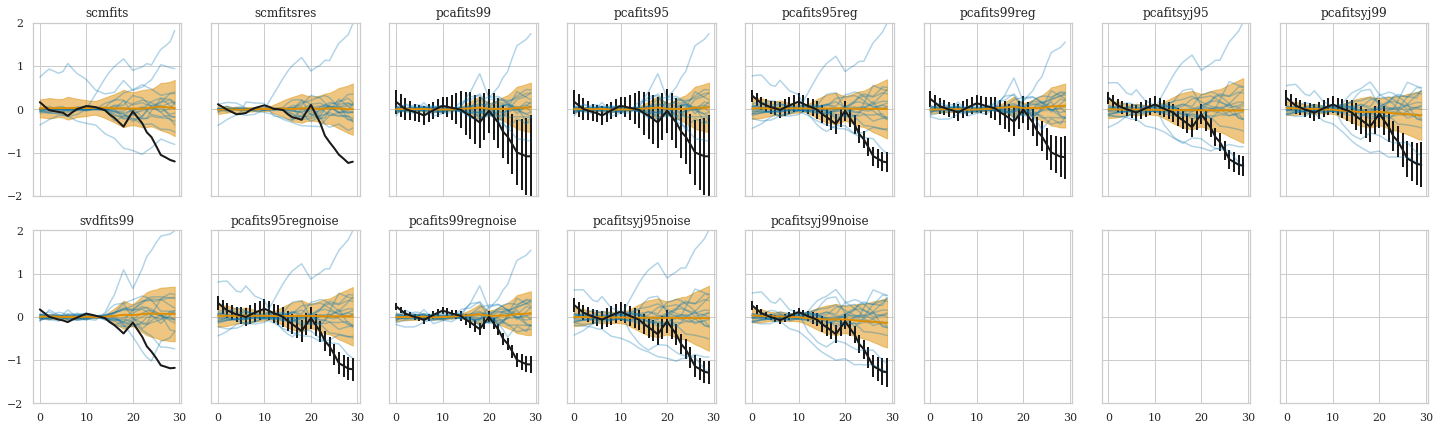

In [73]:
fig, ax = plt.subplots(2, 8, figsize=(25, 7), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])

titles = ['scmfits', 'scmfitsres',  'pca99', 'pcafits95', 'pcafits99reg', 'pcafitsyj99', 'pcafitsyj95', 'svdfits99']
titles = 'scmfits, scmfitsres, pcafits99, pcafits95, pcafits95reg, pcafits99reg, pcafitsyj95, pcafitsyj99'
titles = titles.split(', ')
for j, fits in enumerate([scmfits, scmfitsres, pcafits99, pcafits95, pcafits95reg, pcafits99reg, pcafitsyj95, pcafitsyj99]):
    tmp = []
    axis = ax[0].flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, mmean, 'C1', lw=2)
    try: axis.errorbar(xplot, tmp[itreated], fits[itreated].err, color='k', lw=2)
    except: axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
    axis.set_ylim(-2, 2)
#     axis.set_ylim(-50, 50)

titles = ['scmfits', 'scmfitsres',  'pca99', 'pcafits95', 'pcafits99reg', 'pcafitsyj99', 'pcafitsyj95', 'svdfits99']
titles = 'svdfits99, pcafits95regnoise, pcafits99regnoise, pcafitsyj95noise, pcafitsyj99noise'
titles = titles.split(', ')
for j, fits in enumerate([svdfits99, pcafits95regnoise, pcafits99regnoise, pcafitsyj95noise, pcafitsyj99noise]):
    tmp = []
    axis = ax[1].flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, mmean, 'C1', lw=2)
    try: axis.errorbar(xplot, tmp[itreated], fits[itreated].err, color='k', lw=2)
    except: axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
    axis.set_ylim(-2, 2)
#     axis.set_ylim(-50, 50)

## Vary comp

In [12]:

xx = controls.copy()
means = xx.mean(axis=0)*1
yy = treated.copy()
xplot = np.arange(yy.size)
xx -= means
yy -= means
# mmx = xx[: , :T0].mean(axis=1)*0
# mmy = yy[:T0].mean()*0
# xx -= mmx.reshape(-1, 1)
# yy -= mmy
##
pcapreds = {}
pcapredsyj = {}
pcapredsreg = {}
pcapredsyjnoise = {}
pcapredsregnoise = {}
svdpreds = {}

i = 0 
for ncomp in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
    pca = pcl.pca
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
    ypca, err, pp = pcl.fitanalytic(yy.flatten(), T0, regwt=None, verbose=True, noise=noise)
    ypca += means
    pcapreds[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypca, pcl=pcl, fitp=pp, nc=ncomp, err=err)
    
    pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
    ypca, err, pp, regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 2), verbose=True, retreg=True)
    ypca += means
    pcapredsreg[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypca, pcl=pcl, fitp=pp, nc=ncomp, err=err, regwt=regwt)

    #
    pcl = PCAYJ(xx, ncomp, stdscale=False, normalization='center', whiten=False)
    sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
    ypcayj, ppyj = pcl.fit(yy.flatten(), T0, method='bfgs')
    _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma)
    pcapredsyj[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypcayj+means, pcl=pcl, fitp=ppyj, nc=ncomp, err=err)
    
#     noise = xx[:, :T0].std()
    pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
    pca = pcl.pca
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
    ypca, err, pp,regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 2), verbose=True, noise=noise, retreg=True)
    ypca += means
    pcapredsregnoise[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypca, pcl=pcl, fitp=pp, nc=ncomp, err=err, regwt=regwt, noise=noise)

    #
    pcl = PCAYJ(xx, ncomp, stdscale=False, normalization='center', whiten=False)
    pca = pcl.pca
    noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
    sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
    ypcayj, ppyj = pcl.fit(yy.flatten(), T0, method='bfgs', noise=noise)
    _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma, noise=noise)
    pcapredsyjnoise[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypcayj+means, pcl=pcl, fitp=ppyj, nc=ncomp, err=err, noise=noise)

#     pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
# #     noise = (xx - pcl.unnormalize(pcl.pca.inverse_transform(pcl.pca.transform(pcl.normalize(xx)))))[:, :T0].std()**2
#     pca = pcl.pca
#     noise = pca.explained_variance_.sum()*(1/pca.explained_variance_ratio_.sum()-1)
#     ypca, err, pp,regwt = pcl.fitanalytic(yy.flatten(), T0, regwt=np.logspace(-5, 0), verbose=True, noise=noise, retreg=True)
#     ypca += means
#     pcapredsregnoisepca[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypca, pcl=pcl, fitp=pp, nc=ncomp, err=err, regwt=regwt, noise=noise)

#     #
#     pcl = PCAYJ(xx, ncomp, stdscale=False, normalization='center', whiten=False)
#     sigma = np.array([tools.fitgausspdf(i)[1] for i in pcl.pca.transform(pcl.normalize(xx)).T])
#     noise = (xx - pcl.unnormalize(pcl.pca.inverse_transform(pcl.pca.transform(pcl.normalize(xx)))))[:, :T0].std()**2
#     ypcayj, ppyj = pcl.fit(yy.flatten(), T0, method='bfgs', noise=noise)
#     _, err, _, = pcl.fitanalytic(yy.flatten(), T0, sigma=sigma, noise=noise)
#     pcapredsyjnoisepca[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypcayj+means, pcl=pcl, fitp=ppyj, nc=ncomp, err=err, noise=noise)

    ##
    svl = SVDlearn(controls.copy(), stdscale=False, normalization=None)
    yp, pp = svl.fit(treated.copy(), T0, ncomp, verbose=False)
    svdpreds[ncomp] = GetObject(controls=controls.copy(), treated=treated.copy(), svl=svl, pred=yp, fitp=pp, nc=ncomp)


min rms is at reg = 1.931e+00
min rms is at reg = 1.389e+00
min rms is at reg = 1.000e+00
min rms is at reg = 7.197e+00
min rms is at reg = 1.000e+00
min rms is at reg = 1.000e+01
min rms is at reg = 1.000e+00
min rms is at reg = 2.683e+01
min rms is at reg = 1.000e+00
min rms is at reg = 5.179e+01
min rms is at reg = 1.000e+00
min rms is at reg = 7.197e+01
min rms is at reg = 1.000e+00
min rms is at reg = 1.000e+02
min rms is at reg = 1.389e-03
min rms is at reg = 3.728e-01
min rms is at reg = 1.389e-03
min rms is at reg = 5.179e-01
min rms is at reg = 1.931e-03
min rms is at reg = 1.389e+00


In [30]:
# xx = controls.copy()
# means = xx.mean(axis=0)*1
# yy = treated.copy()
# xplot = np.arange(yy.size)
# xx -= means
# yy -= means

# pcapredsyj = {}

# for ncomp in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
#     print(ncomp)
#     pcayj = PCAYJ(xx, ncomp, whiten=False, normalization=None)
# #     ypcayj, ppyj = pcayj.fit(yy.flatten(), T0, verbose=2, method='nelder-mead')
#     ypcayj, ppyj = pcayj.fit(yy.flatten(), T0, verbose=2, method='bfgs')
# #     ypcayj, ppyj = pcayj.fit(yy.flatten(), T0, verbose=2, method='lbfgs')
#     ypcayj += means
#     pcapredsyj[ncomp] = GetObject(controls=xx+means, treated=yy+means, pred=ypcayj, pcl=pcayj, fitp=ppyj, nc=ncomp)


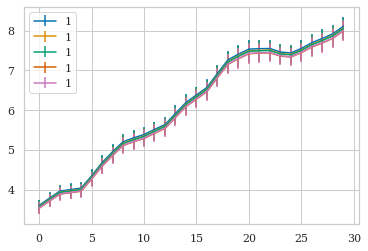

In [72]:
for nn in range(1, 2):
    plt.errorbar(xplot, pcapreds[nn].pred, pcapreds[nn].err, label=nn)
    plt.errorbar(xplot, pcapredsyj[nn].pred, pcapredsyj[nn].err, label=nn)
    plt.errorbar(xplot, pcapredsyjnoise[nn].pred, pcapredsyjnoise[nn].err, label=nn)
#     plt.errorbar(xplot, pcapredsyjnoisepca[nn].pred, pcapredsyjnoisepca[nn].err, label=nn)
    plt.errorbar(xplot, pcapredsreg[nn].pred, pcapredsreg[nn].err, label=nn)
    plt.errorbar(xplot, pcapredsregnoise[nn].pred, pcapredsregnoise[nn].err, label=nn)
#     plt.errorbar(xplot, pcapredsregnoisepca[nn].pred, pcapredsregnoisepca[nn].err, label=nn, ls="--")
    
plt.legend()

# KDE

0.16796748720926533
2 2


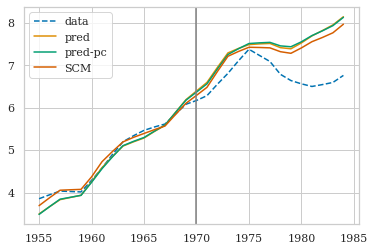

In [32]:
def get_ykde(gg, X1, X2, Y1, gamma=np.logspace(-3, 0, 1000), caty1=True):
    kde = KernelRegression(gg, gamma=gamma)
    kde.fit(X1, X2)
    if len(Y1.shape) <=1: Y1 =  Y1.reshape(1,-1)
    ykde, wts = kde.predict(Y1, retK=True)
    ykde0 = kde.predict(Y1, X1, retK=False)
    ykde = ykde.flatten()
    ykde0 = ykde0.flatten()
    if caty1 == 1: ykde = np.concatenate([Y1.flatten(), ykde])
    elif caty1 == 2: ykde = np.concatenate([ykde0, ykde]) 
    return ykde, kde, wts
 

ii = itreated
xxc = np.concatenate([X[:ii], X[ii+1:]])
yyc = X[ii]
means = xxc.mean(axis=0)*0
stds = xxc.std(axis=0)*0 + 1
xx = (xxc - means)/stds
yy = (yyc - means)/stds

##
X1 = xx[:, :T0]
X2 = xx[:, T0:]
Y1 = yy[:T0]
Y2 = yy[T0:]

#
yp, kde, wts = get_ykde('rbf', X1, X2, Y1, caty1=2)
print(kde.gamma)
yp *= stds
yp += means


plt.plot(years, yyc, '--', label='data')
plt.plot(years, yp, label='pred')
# plt.plot(years, means, 'k--', label='means')


nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
if nc1 <=1 : nc1 +=1 
if nc2 <=1 : nc2 +=1 
print(nc1, nc2)
# nc1, nc2 = 3, 3 
p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
XX1, XX2 = p1.transform(X1), p2.transform(X2)
YY1 = p1.transform(Y1.reshape(1,-1))
ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, caty1=2)
y1, y2 = ykdep[:nc1], ykdep[nc1:]
yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) 
yp *= stds
yp += means
plt.plot(years, yp, label='pred-pc')

ypscm, wts = synth.fit(xx, yy, T0)
plt.plot(years, ypscm*stds + means, label='SCM')
plt.axvline(years[T0], color='gray')
plt.legend()

0.16796748720926533
1.0


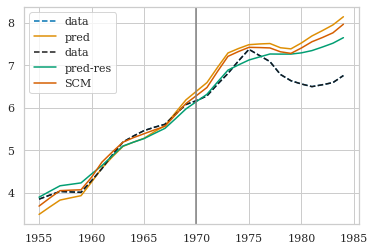

In [33]:

ii = itreated
xxc = np.concatenate([X[:ii], X[ii+1:]])
yyc = X[ii]

##
means = xxc.mean(axis=0)*0
stds = xxc.std(axis=0)*0 + 1
xx = (xxc - means)/stds
yy = (yyc - means)/stds

X1 = xx[:, :T0]
X2 = xx[:, T0:]
Y1 = yy[:T0]
Y2 = yy[T0:]

#
yp, kde, wts = get_ykde('rbf', X1, X2, Y1, caty1=2)
print(kde.gamma)
yp *= stds
yp += means


plt.plot(years, yyc, '--', label='data')
plt.plot(years, yp, label='pred')


xx = xxc - xxc[:, :T0].mean(axis=1).reshape(-1, 1)#(xxc - means)/stds
yy = yyc - yyc[:T0].mean(axis=0)#(xxc - means)/stds

##
X1 = xx[:, :T0]
X2 = xx[:, T0:]
Y1 = yy[:T0]
Y2 = yy[T0:]

#
yp, kde, wts = get_ykde('rbf', X1, X2, Y1, caty1=2)
print(kde.gamma)
# yp *= stds
yp +=  yyc[:T0].mean(axis=0)#(xxc - means)/stds


plt.plot(years, yyc, 'k--', label='data')
plt.plot(years, yp, label='pred-res')
# plt.plot(years, means, 'k--', label='means')


# nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
# if nc1 <=1 : nc1 +=1 
# if nc2 <=1 : nc2 +=1 
# print(nc1, nc2)
# # nc1, nc2 = 3, 3 
# p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
# XX1, XX2 = p1.transform(X1), p2.transform(X2)
# YY1 = p1.transform(Y1.reshape(1,-1))
# ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, caty1=2)
# y1, y2 = ykdep[:nc1], ykdep[nc1:]
# yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) 
# yp *= stds
# yp += means
# plt.plot(years, yp, label='pred-pc')

ypscm, wts = synth.fit(controls, treated, T0)
plt.plot(years, ypscm, label='SCM')
plt.axvline(years[T0], color='gray')
plt.legend()

In [34]:
kdefitsvanilla =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)*0
    stds = xxc.std(axis=0)*0 + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    yp, kde, wts = get_ykde('rbf', X1, X2, Y1,  caty1=2)
    yp *= stds
    yp += means
    kdefitsvanilla[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts)

kdefitsmeans =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*0 + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    yp, kde, wts = get_ykde('rbf', X1, X2, Y1,  caty1=2)
    yp *= stds
    yp += means
    kdefitsmeans[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts)

kdefits =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*1# + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    yp, kde, wts = get_ykde('rbf', X1, X2, Y1,  caty1=2)
    yp *= stds
    yp += means
    kdefits[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts)


kdefitspca99 =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*1# + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    ##
    nc = tools.approximate_rank(xx, 0.99)
    pca = PCA(nc).fit(xx)
    xx, yy = pca.inverse_transform(pca.transform(xx)), pca.inverse_transform(pca.transform(yy.reshape(1, -1)))
    yy = yy.flatten()
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    yp, kde, wts = get_ykde('rbf', X1, X2, Y1,  caty1=2)
    yp *= stds
    yp += means
    kdefitspca99[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts, pca=pca, nc=nc)

print('kdefitspca99 done')

kdefitspcawts99 =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*1# + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    #
    nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
    if nc1 <=1 : nc1 +=1 
    if nc2 <=1 : nc2 +=1 
    p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
    XX1, XX2 = p1.transform(X1), p2.transform(X2)
    YY1 = p1.transform(Y1.reshape(1,-1))
    ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, caty1=2)
    y1, y2 = ykdep[:nc1], ykdep[nc1:]
    yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) 
    yp *= stds
    yp += means
       
    kdefitspcawts99[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts, nc1=nc1, nc2=nc2)

    
print('kdefitspcawts99 done')

    
kdefitspcawts995 =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*1# + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    #
#     nc1, nc2 = 3, 3 # tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
    nc1, nc2 = tools.approximate_rank(X1, 0.995), tools.approximate_rank(X2, 0.995)
    if nc1 <=1 : nc1 +=1 
    if nc2 <=1 : nc2 +=1 
    p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
    XX1, XX2 = p1.transform(X1), p2.transform(X2)
    YY1 = p1.transform(Y1.reshape(1,-1))
    ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, caty1=2)
    y1, y2 = ykdep[:nc1], ykdep[nc1:]
    yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) 
    yp *= stds
    yp += means
        
    kdefitspcawts995[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts, nc1=nc1, nc2=nc2)
    
print('kdefitspcawts995 done')

## KDE FITS RESIDUAL

kdefitsres =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)*0
    stds = xxc.std(axis=0)*0 + 1
    
    xx = (xxc - means)/stds
    mmx = xx[:, :T0].mean(axis=1).reshape(-1, 1)#(xxc - means)/stds
    xx = xx - mmx
    yy = (yyc - means)/stds
    mmy = yy[:T0].mean(axis=0)#(xxc - means)/stds
    yy -= mmy
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    yp, kde, wts = get_ykde('rbf', X1, X2, Y1, caty1=2)
    yp +=  mmy
    yp *= stds
    yp += means
    kdefitsres[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts)

print('kdefitsres done')


kdefitsrespca99 =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)*0
    stds = xxc.std(axis=0)*0 + 1
    
    xx = (xxc - means)/stds
    mmx = xx[:, :T0].mean(axis=1).reshape(-1, 1)#(xxc - means)/stds
    xx = xx - mmx
    yy = (yyc - means)/stds
    mmy = yy[:T0].mean(axis=0)#(xxc - means)/stds
    yy -= mmy
    ##
    nc = tools.approximate_rank(xx, 0.99)
    pca = PCA(nc).fit(xx)
    xx, yy = pca.inverse_transform(pca.transform(xx)), pca.inverse_transform(pca.transform(yy.reshape(1, -1)))
    yy = yy.flatten()

    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    yp, kde, wts = get_ykde('rbf', X1, X2, Y1, caty1=2)
    yp +=  mmy
    yp *= stds
    yp += means
    kdefitsrespca99[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts)

print('kdefitsrespca99 done')

kdefitsrespcawts99 =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)*0
    stds = xxc.std(axis=0)*0 + 1
    
    xx = (xxc - means)/stds
    mmx = xx[:, :T0].mean(axis=1).reshape(-1, 1)#(xxc - means)/stds
    xx = xx - mmx
    yy = (yyc - means)/stds
    mmy = yy[:T0].mean(axis=0)#(xxc - means)/stds
    yy -= mmy
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    #
    nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
    if nc1 <=1 : nc1 +=1 
    if nc2 <=1 : nc2 +=1 
    p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
    XX1, XX2 = p1.transform(X1), p2.transform(X2)
    YY1 = p1.transform(Y1.reshape(1,-1))
    ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, caty1=2)
    y1, y2 = ykdep[:nc1], ykdep[nc1:]
    yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) 
    yp +=  mmy
    yp *= stds
    yp += means
        
    kdefitsrespcawts99[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts, nc1=nc1, nc2=nc2)
    
        

kdefitspca99 done
kdefitspcawts99 done
kdefitspcawts995 done
kdefitsres done
kdefitsrespca99 done


scmfits 0.6521917750834337
scmfitsres 0.5954710305771115
kdefits 0.7620062299744441
kdefitspca99 0.7290780423316945
kdefitspcawts99 0.760886157845452
kdefitsres 0.6210744919956356
kdefitsrespca99 0.5626825384067787
kdefitsrespcawts99 0.6272716159368601


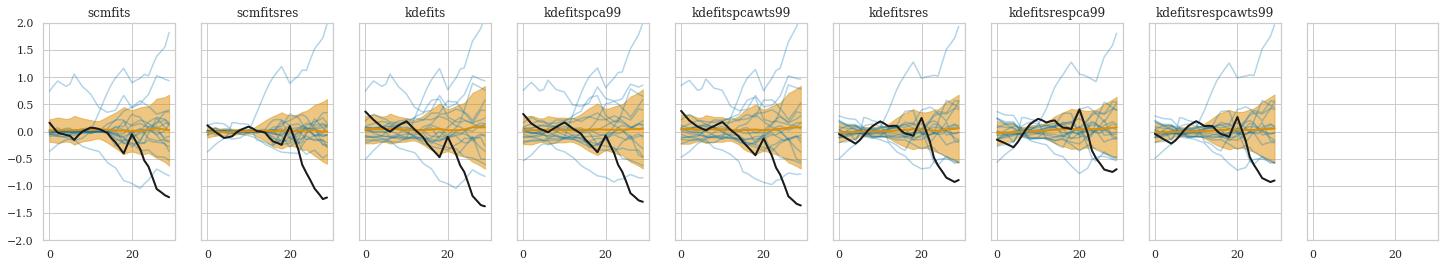

In [35]:
fig, ax = plt.subplots(1, 9, figsize=(25, 4), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])

titles = ['scmfits', 'scmfitsres',  'kdefits', 'kdefitspca99', 'kdefitspcawts99', 
          'kdefitsres', 'kdefitsrespca99', 'kdefitsrespcawts99']
for j, fits in enumerate([scmfits, scmfitsres, kdefits, kdefitspca99, kdefitspcawts99,
                          kdefitsres, kdefitsrespca99, kdefitsrespcawts99]):
    tmp = []
    axis = ax.flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
    axis.set_ylim(-2, 2)
#     axis.set_ylim(-50,50)

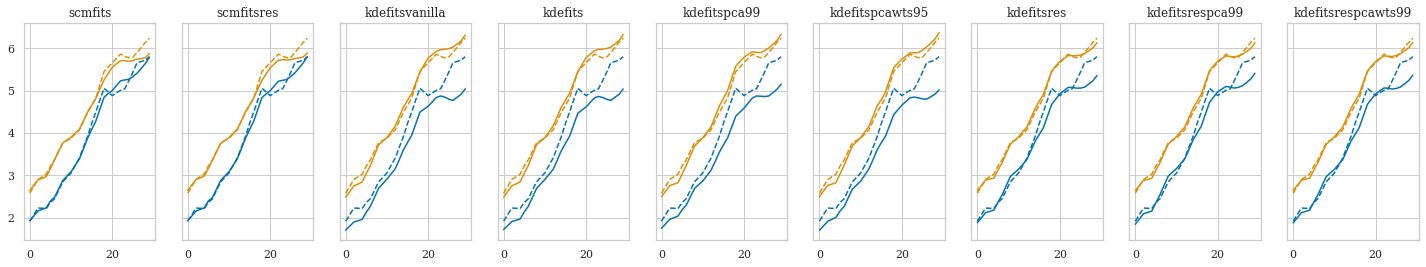

In [36]:
fig, ax = plt.subplots(1, 9, figsize=(25, 4), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])

iis = [4, 9]
titles = ['scmfits', 'scmfitsres', 'kdefitsvanilla', 'kdefits', 'kdefitspca99', 
          'kdefitspcawts95', 'kdefitsres', 'kdefitsrespca99', 'kdefitsrespcawts99']
for j, fits in enumerate([scmfits, scmfitsres, kdefitsvanilla, kdefits, kdefitspca99,
                          kdefitspcawts99, kdefitsres, kdefitsrespca99, kdefitsrespcawts99]):
    axis = ax.flatten()[j]
    for i, ii in enumerate(iis): 
        axis.plot(fits[ii].pred, 'C%d'%i)
        axis.plot(fits[ii].treated, 'C%d--'%i)
    axis.set_title(titles[j])
#     axis.set_ylim(-2, 2)

# GP

RBF(length_scale=2.04)


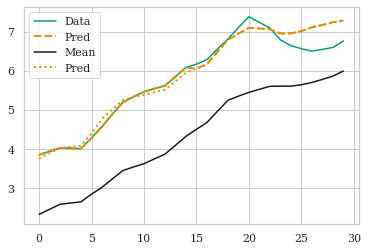

In [37]:
ii = itreated
xxc = np.concatenate([X[:ii], X[ii+1:]])
yyc = X[ii]
means = xxc.mean(axis=0)*1
stds = xxc.std(axis=0)*1# + 1
xx = (xxc - means)/stds
yy = (yyc - means)/stds

xxp = xx.copy()
gp = GPR(kernels.RBF(0.1), n_restarts_optimizer=100, alpha=0.01).fit(xxp[:, :T0], xxp[:, T0:])
print(gp.kernel_)
ypred = np.squeeze(gp.predict(yy[:T0].reshape(1, -1)))
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
yp = np.append(yyc[:T0], ypred*stds[T0:] + means[T0:])
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
ysample = ysample.T*stds[T0:]
err = np.append(np.zeros(T0), ysample.std(axis=0))

plt.plot(yyc, 'C2-', label='Data')
plt.plot(yp, 'C1--', label='Pred',lw=2)
# plt.plot(xxc.T, alpha=0.2, color='b')
plt.plot(means, color='k', label='Mean')

gpalpha = np.dot(np.linalg.inv(np.dot(gp.L_, gp.L_.T)), gp.y_train_)
gpkwts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
wts = np.dot(gpkwts, np.linalg.inv(np.dot(gp.L_, gp.L_.T)))
pre = np.squeeze(np.dot(wts, gp.X_train_))
yp = np.append(pre, ypred)
yp *= stds
yp += means
plt.plot(yp, 'C1:', label='Pred',lw=2)
plt.legend()

In [38]:
# gpalpha = np.dot(np.linalg.inv(np.dot(gp.L_, gp.L_.T)), gp.y_train_)
# gpkwts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
# wts = np.dot(gpkwts, np.linalg.inv(np.dot(gp.L_, gp.L_.T)))

# np.dot(gpkwts, gpalpha) /gp.predict(yy[:T0].reshape(1, -1))
# np.dot(wts, gp.y_train_)/gp.predict(yy[:T0].reshape(1, -1))

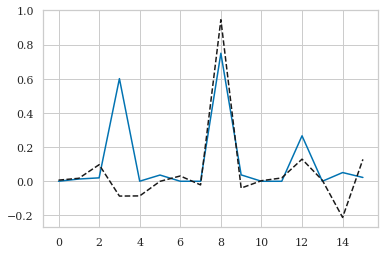

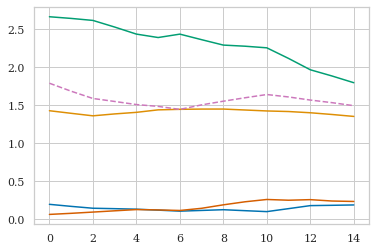

In [39]:
plt.plot(gpkwts/(gpkwts**2).sum()**0.5)
plt.plot(wts/(wts**2).sum()**0.5, 'k--')
plt.show()
wtspos = np.where(wts > 0.1)[0]
plt.plot(gp.X_train_[wtspos].T)
plt.plot(yy[:T0], '--')

In [1]:
kernel = kernels.RBF
kernel = kernels.Matern

    
gpfits = {}
gpfitspca99, gpfitspca95 = {}, {}
# gpfitspca90, gpfitspca70 = {}, {}

for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*1# + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds

 
    def getgppca(ddict, ncomp):
            if ncomp is not None:
                if ncomp == xx.shape[0] or ncomp == T0: ncomp -=1
                pclpre = PCA(ncomp).fit(xx[:, :T0])
                xxpre = pclpre.inverse_transform(pclpre.transform(xx[:, :T0]))
                yypre = pclpre.inverse_transform(pclpre.transform(yy[:T0].reshape(1, -1))).flatten()
#                 pclpost = PCA(ncomp).fit(xx[:, T0:])
#                 xxpost = pclpost.inverse_transform(pclpost.transform(xx[:, T0:]))
#                 yypost = pclpost.inverse_transform(pclpost.transform(yy[T0:].reshape(1, -1))).flatten()
                xxpost = xx[:, T0:]
                yypost = yy[T0:]
                alpha = (xx[:, :T0] - xxpre).std(axis=1)
            else:
                xxpre, xxpost = xx[:, :T0].copy(), xx[:, T0:].copy()
                yypre, yypost = yy[:T0].copy(), yy[T0:].copy()
                alpha = xxpre.std(axis=1)/100.

        #     gp = GPR(kernels.RBF(1, [1e-1, 100]), n_restarts_optimizer=100, alpha=alpha).fit(xxpre, xxpost)
            gp = GPR(kernels.Matern(xxpre.std(axis=0), [xxpre.std()/100, xxpre.std()*100]), n_restarts_optimizer=100, alpha=alpha).fit(xxpre, xxpost)
            yp = np.squeeze(gp.predict(yypre.reshape(1, -1)))
            kwts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
            wts = np.dot(kwts, np.linalg.pinv(np.dot(gp.L_, gp.L_.T)))
            yp = np.append(np.squeeze(np.dot(wts, gp.X_train_)), yp)
            yp = yp*stds + means
            ypred = (np.dot(wts, xx))*stds + means
#             ypred = np.dot(wts, xxc)
            #
            ysample = np.squeeze(gp.sample_y(yypre.reshape(1, -1), 100))        
            ysample = ysample.T*stds[T0:]
            err = np.append(np.zeros(T0), ysample.std(axis=0))
#             if ncomp is not None:   ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=ypred, predp=yp, err=err, pcapre=pclpre, pcapost=pclpost, wts=wts, kwts=kwts)
            if ncomp is not None:   ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=ypred, predp=yp, err=err, pcapre=pclpre,  wts=wts, kwts=kwts)
            else: ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, wts=wts, kwts=kwts)
            
    getgppca(gpfits, None)    
#           
    ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.99)
    getgppca(gpfitspca99, ncomp)
    
    if tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.95) == ncomp:
        gpfitspca95[ss] = gpfitspca99[ss]
    else:
        ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.95)
        getgppca(gpfitspca95, ncomp)
        
#     if tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.90) == ncomp:
#         gpfitspca90[ss] = gpfitspca95[ss]
#     else:
#         ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.90)
#         getgppca(gpfitspca90, ncomp)
    
#     if tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.70) == ncomp:
#         gpfitspca70[ss] = gpfitspca90[ss]
#     else:
#         ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.70)
#         getgppca(gpfitspca70, ncomp)
 

    


NameError: name 'kernels' is not defined

In [41]:
kernel = kernels.RBF
kernel = kernels.Matern

    
# gpfits, gpfitspca99 = {}, {}

# for ii, ss in enumerate(np.arange(N)):
#     xxc = np.concatenate([X[:ii], X[ii+1:]])
#     yyc = X[ii]
#     means = xxc.mean(axis=0)
#     stds = xxc.std(axis=0)*1# + 1
#     xx = (xxc - means)/stds
#     yy = (yyc - means)/stds

#     xxp = xx.copy()
#     gp = GPR(kernel(0.1), n_restarts_optimizer=20, alpha=0.1).fit(xxp[:, :T0], xxp[:, T0:])
#     yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1)))
#     kwts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
#     wts = np.dot(kwts, np.linalg.pinv(np.dot(gp.L_, gp.L_.T)))
#     yp = np.append(np.squeeze(np.dot(wts, gp.X_train_)), yp)
#     yp = yp*stds + means
# #     yp = np.append(yyc[:T0], yp*stds[T0:] + means[T0:])
#     ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
#     ysample = ysample.T*stds[T0:]    
#     err = np.append(np.zeros(T0), ysample.std(axis=0))
#     gpfits[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, wts=wts, kwts=kwts)

    
#     ####
#     nc = tools.approximate_rank(xx-xx.mean(axis=0), 0.99)
#     pca =  PCA(nc).fit(xx)
#     xxp = pca.inverse_transform(pca.transform(xx))
#     alpha = (xx-xxp).std(axis=1)
#     gp = GPR(kernel(0.1), n_restarts_optimizer=20, alpha=alpha).fit(xxp[:, :T0], xxp[:, T0:])
#     yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1)))
#     kwts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
#     wts = np.dot(kwts, np.linalg.pinv(np.dot(gp.L_, gp.L_.T)))
#     yp = np.append(np.squeeze(np.dot(wts, gp.X_train_)), yp)
#     yp = yp*stds + means
# #     yp = np.append(yyc[:T0], yp*stds[T0:] + means[T0:])
#     ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
#     ysample = ysample.T*stds[T0:]
#     err = np.append(np.zeros(T0), ysample.std(axis=0))
#     gpfitspca99[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, pca=pca, wts=wts, kwts=kwts)

    
gpfitspcawts99  =   {}


for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*1# + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    
    #####
    X1 = xx[:, :T0]
    Y1 = yy[:T0]
#     X2 = xx[:, T0:]
#     Y2 = yy[T0:]
    X2 = xx[:, :]
    Y2 = yy[:]
    #
    nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
    if nc1 <=1 : nc1 +=1 
    if nc2 <=1 : nc2 +=1 
    p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
    XX1, XX2 = p1.transform(X1), p2.transform(X2)
    YY1 = p1.transform(Y1.reshape(1,-1))
    stds1, stds2 = XX1.std(axis=0), XX2.std(axis=0)
    XX1 /= stds1
    YY1 /= stds1
    XX2 /= stds2
    
    alpha = 0.01
    gp = GPR(kernel(XX1.std(axis=0), length_scale_bounds=[0.01, 10.]), n_restarts_optimizer=20, alpha=alpha).fit(XX1, XX2)
    yp = np.squeeze(gp.predict(YY1.reshape(1, -1)))
    kwts = gp.kernel_(gp.X_train_, YY1.reshape(1, -1)).flatten()
    wts = np.dot(kwts, np.linalg.pinv(np.dot(gp.L_, gp.L_.T)))
#     yp = np.concatenate([p1.inverse_transform(stds1*np.dot(wts, gp.X_train_)), p2.inverse_transform(stds2*yp)])
    yp = p2.inverse_transform(stds2*yp)
    yp *= stds
    yp += means

    ysample = np.squeeze(gp.sample_y(YY1.reshape(1, -1), 100))        
    ysample = p2.inverse_transform(stds2*ysample.T)
    ysample *= stds
    ysample = ysample[:, T0:]*stds[T0:]
    err = np.append(np.zeros(T0), ysample.std(axis=0))
    gpfitspcawts99[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, nc1=nc1, nc2=nc2, pca1=p1, pca2=p2)


    


In [42]:

    
# gpfitspcawts99  =   {}

# for ii, ss in enumerate(np.arange(N)):
#     xxc = np.concatenate([X[:ii], X[ii+1:]])
#     yyc = X[ii]
#     means = xxc.mean(axis=0)
#     stds = xxc.std(axis=0)*1# + 1
#     xx = (xxc - means)/stds
#     yy = (yyc - means)/stds

    
#     #####
#     X1 = xx[:, :T0]
#     X2 = xx[:, T0:]
#     Y1 = yy[:T0]
#     Y2 = yy[T0:]
#     #
#     nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
#     if nc1 <=1 : nc1 +=1 
#     if nc2 <=1 : nc2 +=1 
#     p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
#     XX1, XX2 = p1.transform(X1), p2.transform(X2)
#     YY1 = p1.transform(Y1.reshape(1,-1))
#     stds1, stds2 = XX1.std(axis=0), XX2.std(axis=0)
#     XX1 /= stds1
#     YY1 /= stds1
#     XX2 /= stds2
    
#     alpha = 1e-10
#     gp = GPR(kernels.RBF(XX1.std(axis=0), length_scale_bounds=[0.01, 10.]),
#              n_restarts_optimizer=100, alpha=alpha).fit(XX1, XX2)
# #     gp = GPR(kernels.RBF(XX1.std(axis=0), length_scale_bounds=[XX1.std(axis=0).min()/3., XX1.std(axis=0).max()*3.]),
# #              n_restarts_optimizer=100, alpha=alpha).fit(XX1, XX2)
# #     gp = GPR(kernels.RBF(0.1, length_scale_bounds=[1e-2, 10]), n_restarts_optimizer=20, alpha=alpha).fit(XX1, XX2)
#     yp2 = np.squeeze(gp.predict(YY1.reshape(1, -1)))
#     kwts = gp.kernel_(gp.X_train_, YY1.reshape(1, -1)).flatten()
#     wts = np.dot(kwts, np.linalg.pinv(np.dot(gp.L_, gp.L_.T)))
#     yp1 = np.dot(wts, gp.X_train_)
# #     yp1 = YY1.flatten()
#     yp = np.concatenate([p1.inverse_transform(yp1*stds1), p2.inverse_transform(yp2*stds2)])
# #     yp = p2.inverse_transform(yp2*stds2)    
#     yp *= stds
#     yp += means

#     gpfitspcawts99[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, nc1=nc1, nc2=nc2, pca1=p1, pca2=p2)


    

# xplot = np.arange(X.shape[1])
# titles = ['SCM', 'KDE', 'GP',  'SCM - Resdiual', 'KDE - Residual',  'GP - Residual']
# for j, fits in enumerate([gpfitspcawts99]):
#     tmp = []
#     print(j, j//2 + j%2)
#     axis = plt.gca()
#     for ii in range(X.shape[0]): 
#         tmp.append(fits[ii].treated - fits[ii].pred)
# #         if i  : tmp[-1][:T0] *= 0
# #         axis.plot(xplot, np.concatenate([tmp[-1][:T0]*0, tmp[-1][T0:]]), 'C0', alpha=0.3)
#         axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
#     tmp = np.array(tmp)
#     mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
#     axis.plot(xplot, tmp[itreated], 'k', lw=2)
#     axis.plot(xplot, mmean, 'C1', lw=2)
#     axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
#     axis.set_title(titles[j])
#     axis.set_ylim(-2, 2)
# #     axis.set_ylim(-100, 100)
#     axis.axhline(0, color='r', ls="--")


In [43]:
# print(np.corrcoef(XX1[:, 0], XX2[:, 0])[1, 0])
# print(np.corrcoef(XX1[:, 0], XX2[:, 1])[1, 0])
# print(np.corrcoef(XX1[:, 1], XX2[:, 0])[1, 0])
# print(np.corrcoef(XX1[:, 1], XX2[:, 1])[1, 0])
# plt.plot(XX1[:, 0], XX2[:, 0], 'o')
# plt.plot(XX1[:, 0], XX2[:, 1], 'o')
# gpfitspcawts99[itreated].gp.kernel_

In [48]:
   
gpfitsres = {}
gpfitspca99res = {}
gpfitspca95res  = {}
gpfitspca90res, gpfitspca70res =  {}, {}

for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)*1
    stds = xxc.std(axis=0)*1 #+ 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    mmx, mmy = xx[:, :T0].mean(axis=1).reshape(-1, 1), yy[:T0].mean()
    xx -= mmx
    yy -= mmy

    ####
#
    def getgppcares(ddict, ncomp):
            if ncomp is not None:
                if ncomp >= xx.shape[0] or ncomp >= xx.shape[1]: ncc = ncomp - 1
                else: ncc = ncomp
                pclpre = PCA(ncc).fit(xx[:, :T0])
                xxpre = pclpre.inverse_transform(pclpre.transform(xx[:, :T0]))
                yypre = pclpre.inverse_transform(pclpre.transform(yy[:T0].reshape(1, -1))).flatten()
#                 pclpost = PCA(ncc).fit(xx[:, T0:])
#                 xxpost = pclpost.inverse_transform(pclpost.transform(xx[:, T0:]))
#                 yypost = pclpost.inverse_transform(pclpost.transform(yy[T0:].reshape(1, -1))).flatten()
                xxpost = xx[:, T0:]
                yypost = yy[T0:]
                alpha = (xx[:, :T0] - xxpre).std(axis=1)
            else:
                xxpre, xxpost = xx[:, :T0].copy(), xx[:, T0:].copy()
                yypre, yypost = yy[:T0].copy(), yy[T0:].copy()
                alpha = xxpre.std(axis=1)/1000.
            #     gp = GPR(kernels.RBF(1, [1e-1, 100]), n_restarts_optimizer=100, alpha=alpha).fit(xxpre, xxpost)
            gp = GPR(kernels.Matern(xxpre.std(), [xxpre.std()/100, xxpre.std()*100]), n_restarts_optimizer=100, alpha=alpha).fit(xxpre, xxpost)
            yp = np.squeeze(gp.predict(yypre.reshape(1, -1)))
            kwts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
            wts = np.dot(kwts, np.linalg.pinv(np.dot(gp.L_, gp.L_.T)))
            yp = np.append(np.squeeze(np.dot(wts, gp.X_train_)), yp)
            yp = (yp + mmy)*stds + means
            ypred = (np.dot(wts, xx) + mmy)*stds + means
            #
            ysample = np.squeeze(gp.sample_y(yypre.reshape(1, -1), 100))        
            ysample = ysample.T*stds[T0:]
            err = np.append(np.zeros(T0), ysample.std(axis=0))
            
#             if ncomp is not None:   ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=ypred, predp=yp, err=err, pcapre=pclpre, pcapost=pclpost, wts=wts, kwts=kwts)
            if ncomp is not None:   ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=ypred, predp=yp, err=err, pcapre=pclpre,  wts=wts, kwts=kwts, samples=ysample)
            else: ddict[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, wts=wts, kwts=kwts)
            
            
    getgppcares(gpfitsres, None)
    
    ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.99)
    getgppcares(gpfitspca99res, ncomp)
    
    if tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.95) == ncomp:
        gpfitspca95res[ss] = gpfitspca99res[ss]
    else:
        ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.95)
        getgppcares(gpfitspca95res, ncomp)
        
    if tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.90) == ncomp:
        gpfitspca90res[ss] = gpfitspca95res[ss]
    else:
        ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.90)
        getgppcares(gpfitspca90res, ncomp)
    
    if tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.70) == ncomp:
        gpfitspca70res[ss] = gpfitspca90res[ss]
    else:
        ncomp = tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.70)
        getgppcares(gpfitspca70res, ncomp)
        
        

In [49]:
gpfitsres[itreated].gp.kernel_, gpfitsres[itreated].gp.kernel

(Matern(length_scale=0.845, nu=1.5), Matern(length_scale=0.112, nu=1.5))

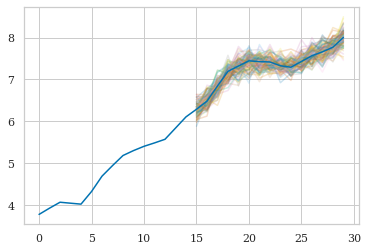

In [50]:
itt = 15
yy = gpfitspca99res[itt].treated - (gpfitspca99res[itt].controls.mean(axis=0))
yy /=  (gpfitspca99res[itt].controls.std(axis=0))
mmy = yy[:T0].mean()
yy -= mmy
yyp = gpfitspca99res[itt].pcapre.inverse_transform(gpfitspca99res[itt].pcapre.transform(yy[:T0].reshape(1, -1)))
ysample = np.squeeze(gpfitspca99res[itt].gp.sample_y(yyp, 100))
ysample2 = (ysample + mmy).T*(gpfitspca99res[itt].controls.std(axis=0))[T0:] + (gpfitspca99res[itt].controls.mean(axis=0))[T0:]
# plt.plot(ysample, alpha=0.2);
# plt.plot(np.squeeze(gpfitsres[itt].gp.predict(yyp)));
# plt.plot(yy[T0:], color='k')

plt.plot(xplot[T0:], ysample2.T, alpha=0.2);
plt.plot(xplot, gpfitspca99res[itt].pred);
# plt.plot(yy[T0:], color='k')

In [ ]:
itt = 15
yy = gpfitspca99res[itt].pred - (gpfitspca99res[itt].controls.mean(axis=0))
yy /=  (gpfitspca99res[itt].controls.std(axis=0))
plt.plot(xplot, yy - yy[:T0].mean(), 'k')
plt.plot(xplot[T0:], gpfitspca99res[15].samples.T, alpha=0.1);

In [ ]:
plt.plot(treated)
plt.plot(gpfitspca99[itreated].pred)
plt.plot(gpfitspca99res[itreated].predp)

In [ ]:
tools.approximate_rank(xx[:, :T0]-xx[:, :T0].mean(axis=0), 0.99)

In [51]:
    
# gpfitsres, gpfitspca99res  =  {}, {}
# for ii, ss in enumerate(np.arange(N)):
#     xxc = np.concatenate([X[:ii], X[ii+1:]])
#     yyc = X[ii]
#     means = xxc.mean(axis=0)*1
#     stds = xxc.std(axis=0)*1 #+ 1
#     xx = (xxc - means)/stds
#     yy = (yyc - means)/stds
#     mmx, mmy = xx[:, :T0].mean(axis=1).reshape(-1, 1), yy[:T0].mean()
#     xx -= mmx
#     yy -= mmy
    
#     xxp = xx.copy()
#     gp = GPR(kernel(0.1), n_restarts_optimizer=20, alpha=0.1).fit(xxp[:, :T0], xxp[:, T0:])
#     yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1)))
#     kwts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
#     wts = np.dot(kwts, np.linalg.pinv(np.dot(gp.L_, gp.L_.T)))
#     yp = np.append(np.squeeze(np.dot(wts, gp.X_train_)), yp)
#     yp = (yp + mmy)*stds + means
# #     yp = np.append(yyc[:T0], (yp + mmy)*stds[T0:] + means[T0:])
#     ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
#     ysample = (ysample.T + mmy)*stds[T0:]
#     err = np.append(np.zeros(T0), ysample.std(axis=0))
#     gpfitsres[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, wts=wts, kwts=kwts)
    
    
#     ####
#     nc = tools.approximate_rank(xx, 0.99)
#     pca =  PCA(nc).fit(xx)
#     xxp = pca.inverse_transform(pca.transform(xx))
#     alpha = (xx-xxp).std(axis=1)
#     gp = GPR(kernel(0.1), n_restarts_optimizer=20, alpha=alpha).fit(xxp[:, :T0], xxp[:, T0:])
#     yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1)))
#     kwts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
#     wts = np.dot(kwts, np.linalg.pinv(np.dot(gp.L_, gp.L_.T)))
#     yp = np.append(np.squeeze(np.dot(wts, gp.X_train_)), yp)
#     yp = (yp + mmy)*stds + means
# #     yp = np.append(yyc[:T0], (yp + mmy)*stds[T0:] + means[T0:])
#     ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
#     ysample = (ysample.T + mmy)*stds[T0:]
#     err = np.append(np.zeros(T0), ysample.std(axis=0))
#     gpfitspca99res[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, pca=pca, wts=wts, kwts=kwts)


gpfitspcawts99res = {}

for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)*1
    stds = xxc.std(axis=0)*1 #+ 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    mmx, mmy = xx[:, :T0].mean(axis=1).reshape(-1, 1), yy[:T0].mean()
    xx -= mmx
    yy -= mmy
    #####
    X1 = xx[:, :T0]
    Y1 = yy[:T0]
#     X2 = xx[:, T0:]
#     Y2 = yy[T0:]
    X2 = xx[:, :]
    Y2 = yy[:]
    
    #
    nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
    if nc1 <=1 : nc1 +=1 
    if nc2 <=1 : nc2 +=1 
    p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
    XX1, XX2 = p1.transform(X1), p2.transform(X2)
    YY1 = p1.transform(Y1.reshape(1,-1))
    stds1, stds2 = XX1.std(axis=0), XX2.std(axis=0)
    XX1 /= stds1
    YY1 /= stds1
    XX2 /= stds2
    
    alpha = 0.001
    gp = GPR(kernel(XX1.std(axis=0)/3., length_scale_bounds=[0.01, 10]), n_restarts_optimizer=20, alpha=alpha).fit(XX1, XX2)
    yp = np.squeeze(gp.predict(YY1.reshape(1, -1)))
    kwts = gp.kernel_(gp.X_train_, YY1.reshape(1, -1)).flatten()
    wts = np.dot(kwts, np.linalg.pinv(np.dot(gp.L_, gp.L_.T)))
    yp = p2.inverse_transform(yp*stds2)
#     yp = np.concatenate([p1.inverse_transform(np.dot(wts, gp.X_train_)), p2.inverse_transform(yp)])
#     yp = np.concatenate([Y1, p2.inverse_transform(yp)])
    yp = (yp + mmy)*stds + means
    
    ysample = np.squeeze(gp.sample_y(YY1.reshape(1, -1), 100))        
    ysample = p2.inverse_transform(stds2*ysample.T)
    ysample *= stds
    ysample = ysample[:, T0:]*stds[T0:]
    err = np.append(np.zeros(T0), ysample.std(axis=0))

    gpfitspcawts99res[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, pca1=p1, pca2=p2, wts=wts, kwts=kwts)
     
    


In [52]:
# itreated = 4
# for itreated in range(17):
#     plt.errorbar(xplot, gpfitsres[itreated].pred - gpfitsres[itreated].treated, gpfitsres[itreated].err)
# #     plt.errorbar(xplot, gpfits[itreated].pred - gpfitsres[itreated].treated, gpfits[itreated].err)
#     plt.errorbar(xplot+0.2, gpfitspca99res[itreated].pred - gpfitspca99res[itreated].treated, gpfitspca99res[itreated].err)
#     plt.title(itreated)
#     plt.axhline(0)
#     plt.show()
# # itreated = 15
# # plt.errorbar(xplot, gpfitsres[itreated].pred - gpfitsres[itreated].treated, gpfitsres[itreated].err)


gp 0.7689713498643908
gp pca99 0.7064200828379711
gp pcawts99 1.11166158678337
gpres 0.6018129486086311
gp res pca99 0.5614823279086733
gpfitspcawts99res 0.7717765389099276


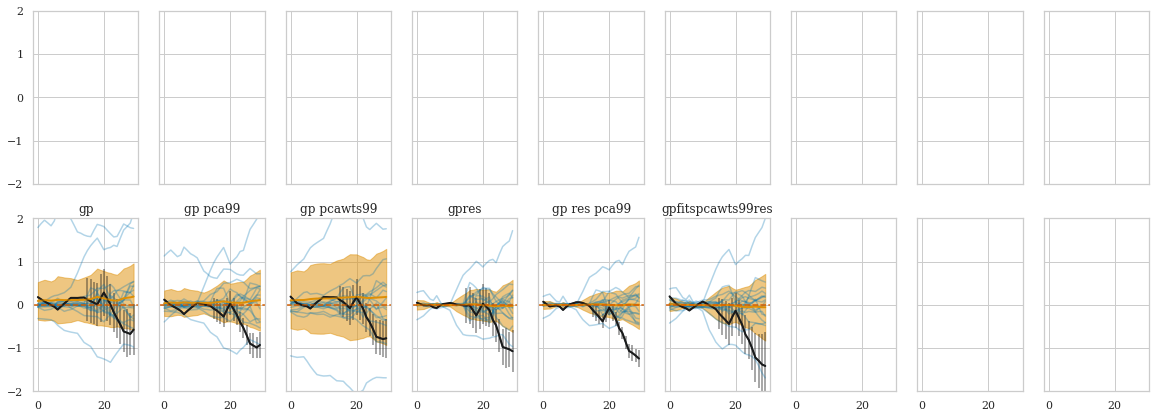

In [53]:

fig, ax = plt.subplots(2, 9, figsize=(20, 7), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])

# titles = ['scmfits', 'scmfitsres',   'pcafits99', 'pcafits99reg', 'pcafitsyj99', 'kdefitspca99', 'kdefitsres', 'kdefitsrespca99']
# for j, fits in enumerate([scmfits, scmfitsres,  pcafits99, pcafits99reg, pcafitsyj99, kdefitspca99, kdefitsres, kdefitsrespca99]):
#     print(titles[j])
#     tmp = []
#     axis = ax[0].flatten()[j]
#     for ii in range(X.shape[0]): 
#         tmp.append(fits[ii].treated - fits[ii].pred)
#         axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
#     tmp = np.array(tmp)
#     mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
#     print(titles[j], sstd[-1])
#     axis.plot(xplot, tmp[itreated], 'k', lw=2)
#     axis.plot(xplot, mmean, 'C1', lw=2)
#     axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
#     axis.set_title(titles[j])
#     axis.set_ylim(-2, 2)
#     axis.axhline(0, color='r', ls="--")

    
titles = ['gp', 'gp pca99', 'gp pcawts99', 'gpres', 'gp res pca99', 'gpfitspcawts99res']
for j, fits in enumerate([gpfits, gpfitspca99, gpfitspcawts99, gpfitsres, gpfitspca99res, gpfitspcawts99res]):
    tmp = []
    axis = ax[1].flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.errorbar(xplot, tmp[itreated], fits[itreated].err, color='k', alpha=0.5)
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
    axis.set_ylim(-2, 2)
#     axis.set_ylim(-50, 50)
    axis.axhline(0, color='r', ls="--")


scmfits
scmfits 0.6521917750834337
scmfitsres
scmfitsres 0.5954710305771115
kdefitspca99
kdefitspca99 0.7290780423316945
kdefitsres
kdefitsres 0.6210744919956356
kdefitsrespca99
kdefitsrespca99 0.5626825384067787
gp 0.7689713498643908
gp pca99 0.7064200828379711
gp pcawts99 1.11166158678337
gpres 0.6018129486086311
gp res pca99 0.5614823279086733
gpfitspcawts99res 0.7717765389099276


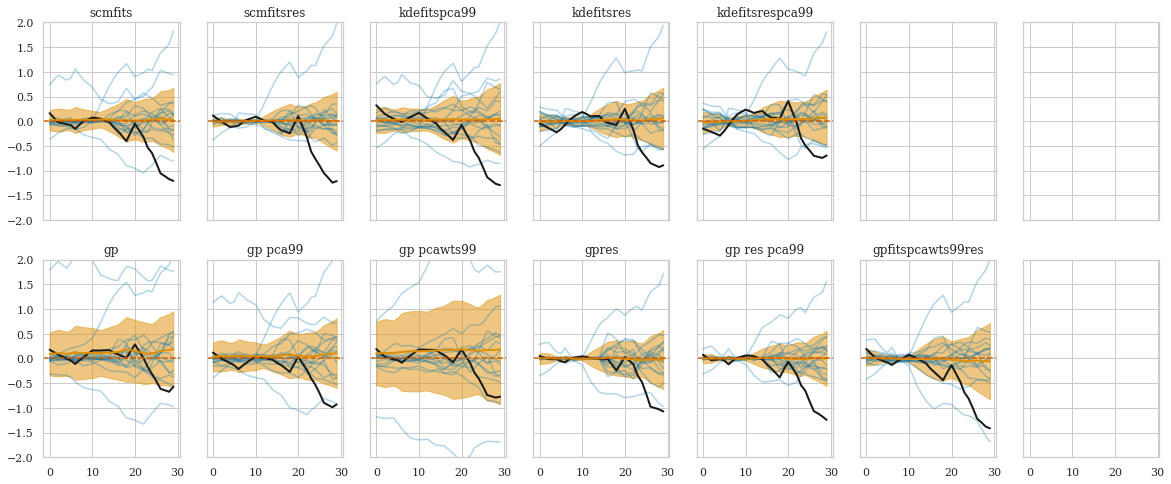

In [54]:
fig, ax = plt.subplots(2, 7, figsize=(20, 8), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])

titles = ['scmfits', 'scmfitsres',   'kdefitspca99', 'kdefitsres', 'kdefitsrespca99']
for j, fits in enumerate([scmfits, scmfitsres,  kdefitspca99, kdefitsres, kdefitsrespca99]):
    print(titles[j])
    tmp = []
    axis = ax[0].flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
    axis.set_ylim(-2, 2)
    axis.axhline(0, color='r', ls="--")

    
titles = ['gp', 'gp pca99', 'gp pcawts99', 'gpres', 'gp res pca99', 'gpfitspcawts99res']
for j, fits in enumerate([gpfits, gpfitspca99, gpfitspcawts99, gpfitsres, gpfitspca99res, gpfitspcawts99res]):
    tmp = []
    axis = ax[1].flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    print(titles[j], sstd[-1])
    axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
    axis.set_ylim(-2, 2)
#     axis.set_ylim(-100, 100)
    axis.axhline(0, color='r', ls="--")


0 0
1 1
2 1
3 2
4 2
5 3


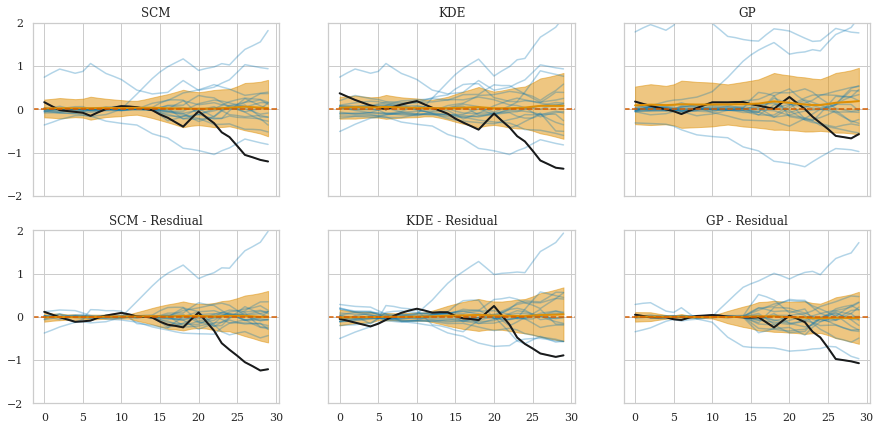

In [55]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7), sharex=True, sharey=True)

xplot = np.arange(X.shape[1])
    
# titles = ['gp', 'gp pca99', 'gp pcawts99', 'gpres', 'gp res pca99', 'gp res pcawts99']
# for j, fits in enumerate([gpfits, gpfitspca99, gpfitspcawts99, gpfitsres, gpfitspca99res, gpfitspcawts99res]):
titles = ['SCM', 'KDE', 'GP',  'SCM - Resdiual', 'KDE - Residual',  'GP - Residual']
for j, fits in enumerate([scmfits,  kdefits,  gpfits, scmfitsres, kdefitsres, gpfitsres]):
# titles = ['SCM',  'GP', 'GP - Residual']
# for j, fits in enumerate([scmfits,  gpfits]):
    tmp = []
    print(j, j//2 + j%2)
    axis = ax.flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
#         if i  : tmp[-1][:T0] *= 0
#         axis.plot(xplot, np.concatenate([tmp[-1][:T0]*0, tmp[-1][T0:]]), 'C0', alpha=0.3)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
    axis.set_ylim(-2, 2)
#     axis.set_ylim(-100, 100)
    axis.axhline(0, color='r', ls="--")

# titles = ['SCM',  'GP', 'GP - Residual']
# for j, fits in enumerate([scmfits,  gpfits]):
#     tmp = []
#     axis = ax[1].flatten()[j]
#     for ii in range(X.shape[0]): 
#         tmp.append(fits[ii].treated - fits[ii].pred)
# #         axis.plot(xplot, np.concatenate([tmp[-1][:T0]*0, tmp[-1][T0:]]), 'C0', alpha=0.3)
#         axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
#     tmp = np.array(tmp)
#     mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
#     axis.plot(xplot, tmp[itreated], 'k', lw=2)
#     axis.plot(xplot, mmean, 'C1', lw=2)
#     axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
#     axis.set_title(titles[j])
# #     axis.set_ylim(-2, 2)
#     axis.set_ylim(-100, 100)
#     axis.axhline(0, color='r', ls="--")


# plot

In [ ]:

plt.plot(scmfitsres[itreated].controls.mean(axis=0), 'gray')
plt.plot(scmfitsres[itreated].treated, 'k-')
plt.plot(scmfits[itreated].pred, '--', label='SCM')
plt.plot(scmfitsres[itreated].pred, '--', label='SCM Res')
plt.plot(pcafits99[itreated].pred, '--', label='PCR')
plt.plot(pcafitsyj99[itreated].pred, label='Prob PCR')
plt.plot(kdefitsres[itreated].pred, label='KDE')
plt.plot(gpfitsres[itreated].pred, label='GPR')
plt.legend()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(years, treated, 'k')
for ncomp in range(2, 10):
    ax[0].plot(years, pcapreds[ncomp].pred, label=ncomp)
ax[0].legend()

ax[1].plot(years, treated, 'k')
for ncomp in range(2, 10):
    ax[1].plot(years, pcapredsyj[ncomp].pred)


In [ ]:
pcafitsyj95[15].fitp

In [ ]:
pcafitsyj99[15].fitp

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7), sharex=True, sharey=True)

xplot = years #np.arange(X.shape[1])
    
titles = ['SCM', 'SCM Residual', 'PCR',  'PCR - Prior', 'KDE - Residual',  'GP - Residual']
for j, fits in enumerate([scmfits,  scmfitsres, pcafits95,  pcafitsyj95, kdefitsres, gpfitsres]):
    tmp = []
    print(j, j//2 + j%2)
    axis = ax.flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
#         if i  : tmp[-1][:T0] *= 0
#         axis.plot(xplot, np.concatenate([tmp[-1][:T0]*0, tmp[-1][T0:]]), 'C0', alpha=0.3)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    try: axis.errorbar(xplot, tmp[itreated], fits[itreated].err, color= 'k', lw=2)
    except:     axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
    axis.set_ylim(-2, 2)
#     axis.set_ylim(-100, 100)
    axis.axhline(0, color='r', ls="--")
    axis.axvline(years[T0], color='r', ls="--")
# plt.savefig('../new_figs/basque_all95.png')

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7), sharex=True, sharey=True)

xplot = years #np.arange(X.shape[1])
    
titles = ['SCM', 'SCM Residual', 'PCR',  'PCR - Prior', 'KDE - Residual',  'GP - Residual']
for j, fits in enumerate([scmfits,  scmfitsres, pcafits95,  pcafitsyj95, kdefitsres, gpfitsres]):
    tmp = []
    print(j, j//2 + j%2)
    axis = ax.flatten()[j]
    for ii in range(X.shape[0]): 
        tmp.append(fits[ii].treated - fits[ii].pred)
#         if i  : tmp[-1][:T0] *= 0
#         axis.plot(xplot, np.concatenate([tmp[-1][:T0]*0, tmp[-1][T0:]]), 'C0', alpha=0.3)
        axis.plot(xplot, tmp[-1], 'C0', alpha=0.3)
    tmp = np.array(tmp)
    mmean, sstd = tmp.mean(axis=0), tmp.std(axis=0)
    try: axis.errorbar(xplot, tmp[itreated], fits[itreated].err, color= 'k', lw=2)
    except:     axis.plot(xplot, tmp[itreated], 'k', lw=2)
    axis.plot(xplot, mmean, 'C1', lw=2)
    axis.fill_between(xplot, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(titles[j])
    axis.set_ylim(-2, 2)
#     axis.set_ylim(-100, 100)
    axis.axhline(0, color='r', ls="--")
    axis.axvline(years[T0], color='r', ls="--")
# plt.savefig('../new_figs/basque_all99.png')    

# Save

In [65]:
# titles = ['scmfits','scmfitsres']
# for j, fits in enumerate([scmfits,  scmfitsres]):
#     tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(X.shape[0])])
#     np.save('../tmpdata/basque//%s'%titles[j], tosave)
    
# titles = 'pcafits95, pcafits99'
# titles = titles.split(', ')
# for j, fits in enumerate([pcafits95, pcafits99]):
#     try: tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(X.shape[0])])
#     except: 
#         print(titles[j])
#         tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(1, 11)])
#     np.save('../tmpdata/basque//%s'%titles[j], tosave)

# titles = 'glfits'
# titles = titles.split(', ')
# for j, fits in enumerate([glfits]):
#     try: tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(X.shape[0])])
#     except: 
#         print(titles[j])
#         tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(1, 11)])
#     np.save('../tmpdata/basque//%s'%titles[j], tosave)

# titles = 'pcafits95, pcafits99, pcafits95reg, pcafits99reg, pcafitsyj95, pcafitsyj99, pcafits95regnoise, pcafits99regnoise, pcafitsyj95noise, pcafitsyj99noise'
# titles = titles.split(', ')
# for j, fits in enumerate([pcafits95, pcafits99, pcafits95reg, pcafits99reg, pcafitsyj95, pcafitsyj99, pcafits95regnoise, pcafits99regnoise, pcafitsyj95noise, pcafitsyj99noise]):
#     try: tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(X.shape[0])])
#     except: 
#         print(titles[j])
#         tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(1, 11)])
#     np.save('../tmpdata/basque//%s'%titles[j], tosave)

    
# # titles = 'svdfits99, pcafits95, pcafits99, pcafits95reg, pcafits99reg, pcafitsyj95, pcafitsyj99, pcafits95regnoise, pcafits99regnoise, pcafitsyj95noise, pcafitsyj99noise'
# # titles = titles.split(', ')
# titles = 'pcafits95regnoisepca, pcafits99regnoisepca, pcafitsyj95noisepca, pcafitsyj99noisepca'
# titles = titles.split(', ')
# for j, fits in enumerate([pcafits95regnoisepca, pcafits99regnoisepca, pcafitsyj95noisepca, pcafitsyj99noisepca]):
#     try: tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(X.shape[0])])
#     except: 
#         print(titles[j])
#         tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(1, 11)])
#     np.save('../tmpdata/basque//%s'%titles[j], tosave)

# titles = 'kdefits, kdefitspca99, kdefitspcawts99, kdefitsres, kdefitsrespca99, kdefitsrespcawts99'
# titles = titles.split(', ')
# for j, fits in enumerate([kdefits, kdefitspca99, kdefitspcawts99, kdefitsres, kdefitsrespca99, kdefitsrespcawts99]):
#     tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(X.shape[0])])
#     np.save('../tmpdata/basque//%s'%titles[j], tosave)

# titles = 'gpfitspcawts99, gpfitspcawts99res'
# titles = titles.split(', ')
# for j, fits in enumerate([gpfitspcawts99, gpfitspcawts99res ]):
#     tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(X.shape[0])])
#     np.save('../tmpdata/basque//%s'%titles[j], tosave)    

# titles = 'gpfits, gpfitsres, gpfitspca99, gpfitspca99res, gpfitspca95, gpfitspca95res'
# titles = titles.split(', ')
# for j, fits in enumerate([gpfits, gpfitsres, gpfitspca99, gpfitspca99res, gpfitspca95, gpfitspca95res]):
#     tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(X.shape[0])])
#     np.save('../tmpdata/basque//%s'%titles[j], tosave)    


# titles = 'pcapreds, pcapredsreg, pcapredsyj, svdpreds, pcapredsregnoise, pcapredsyjnoise'
# titles = titles.split(', ')
# for j, fits in enumerate([pcapreds, pcapredsreg, pcapredsyj, svdpreds, pcapredsregnoise, pcapredsyjnoise]):
#     try: tosave = np.array([[fits[ii].treated, fits[ii].pred, fits[ii].err] for ii in range(1, 11)])
#     except: 
#         print(titles[j])
#         tosave = np.array([[fits[ii].treated, fits[ii].pred] for ii in range(1, 11)])
#     np.save('../tmpdata/basque//%s'%titles[j], tosave)    


{}

In [ ]:
# for ss in [itreated]:
#     w1, w2 = kdefits[ss].wts.flatten(), scmfits[ss].wts.flatten()
#     w1 /= w1.sum()
#     w2 /= w2.sum()
#     w1[w1<0.01] = 0
#     w2[w2<0.01] = 0
#     print(ss, np.corrcoef(w1, w2)[0, 1])
    
#     fig, ax = plt.subplots(1,1, figsize=(8, 5))
#     ax = [ax]
#     ii=0
#     ax[ii].plot(years, scmfits[ss].treated, 'k',lw=2, label='Data')

#     ax[ii].plot(years, scmfits[ss].pred, 'k:', label='SCM')

#     ax[ii].plot(years, svdfitsfits[ss].pred, 'C0-', label='SVD')
#     ax[ii].plot(years, svdfitsfitsc[ss].pred, 'C0--', lw=2, label='SVD-C')
#     ax[ii].plot(years, svdfitsfitsc3[ss].pred, 'C0:', lw=2, label='SVD-C3')

#     ax[ii].plot(years, kdefits[ss].pred, 'C1-', label='KDE')
#     ax[ii].plot(years, kdefitspca[ss].pred, 'C1--', label='KDE-PCA')
#     ax[ii].plot(years, kdefitspca3[ss].pred, 'C1:', label='KDE-PCA3')
    

#     ax[ii].plot(years, pcafits[ss].pred, 'C2', label='PCA')
#     ax[ii].plot(years, pcafits3[ss].pred, 'C2--', label='PCA-3')
#     ax[ii].plot(years, pcafitsyj[ss].pred, 'C4', label='PCA-YJ')
#     ax[ii].plot(years, pcafitsyj3[ss].pred, 'C4--', label='PCA-YJ-3')
    
#     ax[ii].errorbar(years, gpfits[ss].pred, gpfits[ss].err, color='C7', label='GP', elinewidth=0.5)
    
#     ax[ii].errorbar(years+0.25, gpfitspca[ss].pred, gpfitspca[ss].err, color='C9', ls="-", lw=1, elinewidth=0.5, label='GP-PCA')
#     ax[ii].errorbar(years-0.25, gpfitspca3[ss].pred, gpfitspca3[ss].err, color='C9', ls="--",  lw=2, elinewidth=0.5, label='GP-PCA3')

# plt.legend(loc=2, bbox_to_anchor=(1, 1))
# plt.axvline(T0, color='k', ls="--")
# # plt.xlim(1970, 2005)
# # plt.ylim(0, 200)

In [ ]:
diffscm  = np.zeros_like(controls)
diffsvd, diffsvdc, diffsvdc3  = np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls)
diffkde, diffkdepca, diffkdepca3 = np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls)
diffpca, diffpca3, diffpcayj, diffpcayj3 = np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls)
diffgp, diffgppca, diffgppca3 = np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls)

for ii, ss in enumerate(np.arange(N-1)):
    if ii == itreated: continue
    xx = pcafits[ss].controls
    means, stds = xx.mean(axis=0), xx.std(axis=0)
    yy = pcafits[ss].treated

    diffscm[ii] = (yy-scmfits[ss].pred)

    diffpca[ii] = (yy-pcafits[ss].pred)
    diffpcayj[ii] = (yy-pcafitsyj[ss].pred)    
    diffpca3[ii] = (yy-pcafits3[ss].pred)
#     diffpcayj3[ii] = (yy-pcafitsyj3[ss].pred)
    
#     diffsvd[ii] = (yy-svdfitsfits[ss].pred)
#     diffsvdc[ii] = (yy-svdfitsfitsc[ss].pred)
#     diffsvdc3[ii] = (yy-svdfitsfitsc3[ss].pred)
    
    diffkde[ii] = (yy-kdefits[ss].pred)
    diffkdepca[ii] = (yy-kdefitspca[ss].pred)
    diffkdepca3[ii] = (yy-kdefitspca3[ss].pred)
    
    diffgp[ii] = (yy-gpfits[ss].pred)
    diffgppca[ii] = (yy-gpfitspca[ss].pred)
    diffgppca3[ii] = (yy-gpfitspca3[ss].pred)


In [ ]:



tmpy = pcafits[itreated].treated

fig, axar = plt.subplots(3, 5, figsize=(20, 14), sharex=True, sharey=True)
ax = axar.flatten()

dd = diffscm.copy()
ax[0].plot(years, dd.T, 'C0-', alpha=0.5)
ax[0].plot(years, dd.mean(axis=0), 'C1', alpha=0.5)
ax[0].fill_between(years, dd.mean(axis=0) - dd.std(axis=0), dd.mean(axis=0) + dd.std(axis=0), color='C2', alpha=0.5)
ax[0].plot(years, tmpy - scmfits[itreated].pred, 'k-', alpha=1)
ax[0].set_title('SCM')
ax[0].set_ylabel("Data - Pred")


def tmpplot(ii, title, dd, ddca):
    ax[ii].plot(years, dd.T, 'C0-', alpha=0.5)
    ax[ii].plot(years, dd.mean(axis=0), 'C1', alpha=0.5)
    ax[ii].fill_between(years, dd.mean(axis=0) - dd.std(axis=0), dd.mean(axis=0) + dd.std(axis=0), color='C2', alpha=0.5)
    ax[ii].plot(years, tmpy - ddca, 'k-', alpha=1)
    ax[ii].set_title(title)

ii, title, dd, ddca = 1, 'SVD', diffsvd.copy(), svdfitsfits[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 2, 'SVD-center', diffsvdc.copy(), svdfitsfitsc[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 3, 'SVD-center3', diffsvdc3.copy(), svdfitsfitsc3[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 4, 'KDE', diffkde.copy(), kdefits[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 5, 'KDE-PCA', diffkdepca.copy(), kdefitspca[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 6, 'KDE-PCA3', diffkdepca3.copy(), kdefitspca3[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 7, 'PCA', diffpca.copy(), pcafits[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 8, 'PCA-YJ', diffpcayj.copy(), pcafitsyj[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 9, 'PCA-3', diffpca3.copy(), pcafits3[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 10, 'PCA-YJ3', diffpcayj3.copy(), pcafitsyj3[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 11, 'GP', diffgp.copy(), gpfits[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 12, 'GP-PCA', diffgppca.copy(), gpfitspca[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 13, 'GP-PCA3', diffgppca3.copy(), gpfitspca3[itreated].pred
tmpplot(ii, title, dd, ddca)

for axis in ax:
#     axis.set_xlim(1969, 2005)
    axis.set_ylim(-100, 200)
    axis.axvline(T0, color='r', ls='--')


In [ ]:
plt.plot(kdefits[1].treated)
plt.plot(kdefits[1].pred)

In [ ]:
plt.plot(scmfits[3].treated)
plt.plot(scmfits[3].treated)


# Load and plot

In [273]:
import os


In [385]:
ttax2000 = {}
for ff in os.listdir('../tmpdata/prop99_2000/'):
    ttax2000[ff.split('.')[0]] = np.load('../tmpdata/prop99_2000/' + ff)
    
ttax2005 = {}
for ff in os.listdir('../tmpdata/prop99_2005/'):
    ttax2005[ff.split('.')[0]] = np.load('../tmpdata/prop99_2005/' + ff)
    
basque = {}
for ff in os.listdir('../tmpdata/basque//'):
    basque[ff.split('.')[0]] = np.load('../tmpdata/basque//' + ff)
    
    
itreated0 = 4
itreated1 = 15
years0 = np.arange(1970, 2001)
years1 = np.arange(1955, 1985)
years2 = np.arange(1970, 2006)
ivtreated0 = 1988
ivtreated1 = 1970
yyears = [years0, years1, years2]
itt = [itreated0, itreated1, itreated0]
ivt = [1988, 1970, 1988]
dds = [ttax2000, basque, ttax2005]


In [386]:
ttax2005.keys()

dict_keys(['pcafitsyj99', 'gpfitspca99res', 'pcafits95regnoise', 'gpfits', 'pcafitsyj99noise', 'pcapredsyj', 'kdefitsrespca99', 'pcafitsyj99noisepca', 'gpfitspca99', 'pcafits95reg', 'kdefitsres', 'pcafits95regnoisepca', 'pcafits99', 'pcafits99regnoisepca', 'pcapreds', 'gpfitspcawts99', 'pcafits99regnoise', 'pcapredsyjnoisepca', 'scmfitsres', 'kdefits', 'kdefitspca99', 'pcafits99reg', 'pcafits95', 'pcafitsyj95noisepca', 'gpfitspca95', 'pcapredsreg', 'gpfitspcawts99res', 'pcafitsyj95noise', 'pcapredsregnoise', 'kdefitspcawts99', 'gpfitsres', 'kdefitsrespcawts99', 'gpfitspca95res', 'pcapredsyjnoise', 'svdfits99', 'scmfits', 'pcafitsyj95', 'pcapredsregnoisepca', 'svdpreds'])

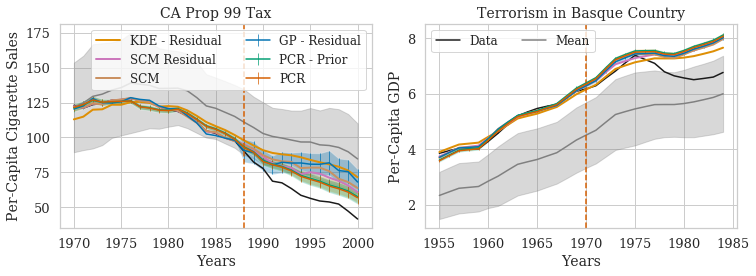

In [407]:
fig, ax = plt.subplots(1, 2, figsize=(10.5, 4))
fsize = 14

ppp = 95
labels = ['SCM', 'SCM Residual', 'PCR',  'PCR - Prior', 'KDE - Residual',  'GP - Residual'][::-1]
if ppp == 99:  kkeys = 'scmfits, scmfitsres, pcafits99regnoisepca, pcafitsyj99noisepca, kdefitsres, gpfitspca99res'
elif ppp == 95: kkeys = 'scmfits, scmfitsres, pcafits95regnoisepca, pcafitsyj95noisepca, kdefitsres, gpfitspca95res'
kkeys = kkeys.split(', ')[::-1]

for ik, kk in enumerate(kkeys):
    dd1 = basque[kk]
    dd0 = ttax2000[kk]
    dd = [dd0, dd1]

    for i in range(2):
        lbl, lblm = None, None

        mm = np.concatenate([dd[i][:itt[i]], dd[i][itt[i]+1:]]).mean(axis=0)[0]
        stds = np.concatenate([dd[i][:itt[i]], dd[i][itt[i]+1:]]).std(axis=0)[0]
        if i : lbl = 'Data'
        if ik == 0: ax[i].plot(yyears[i], dd[i][itt[i]][0], 'k', label=lbl)
        if i : lbl = 'Mean'
        if ik == 0:  
            ax[i].plot(yyears[i], mm, 'gray', label=lbl)
            ax[i].fill_between(yyears[i], mm - stds, mm + stds, color='gray', alpha=0.3)

        if i == 0 : lblm = labels[ik]
        try: 
            ax[i].errorbar(yyears[i], dd[i][itt[i]][1], dd[i][itt[i]][2], label = lblm, elinewidth=0.7)
            ax[i].fill_between(yyears[i], dd[i][itt[i]][1] - dd[i][itt[i]][2], dd[i][itt[i]][1] + dd[i][itt[i]][2], alpha=0.3)
        except : ax[i].plot(yyears[i], dd[i][itt[i]][1], label = lblm, lw=2)


for axis in ax : 
    axis.legend(fontsize=fsize-2, ncol=2)
    axis.tick_params(labelsize=fsize-1)
    axis.set_xlabel('Years', fontsize=fsize)
ax[0].axvline(1988, color='r', ls="--")
ax[1].axvline(1970, color='r', ls="--")
ax[0].set_ylabel('Per-Capita Cigarette Sales', fontsize=fsize)
ax[1].set_ylabel('Per-Capita GDP', fontsize=fsize)
ax[0].set_title('CA Prop 99 Tax', fontsize=fsize)
ax[1].set_title('Terrorism in Basque Country', fontsize=fsize)
plt.tight_layout()
# if ppp == 99:
#     plt.savefig('../new_figs/cf99.png')
#     plt.savefig('../new_figs/cf99.pdf')
# elif ppp == 95:
#     plt.savefig('../new_figs/cf95.png')
#     plt.savefig('../new_figs/cf95.pdf')

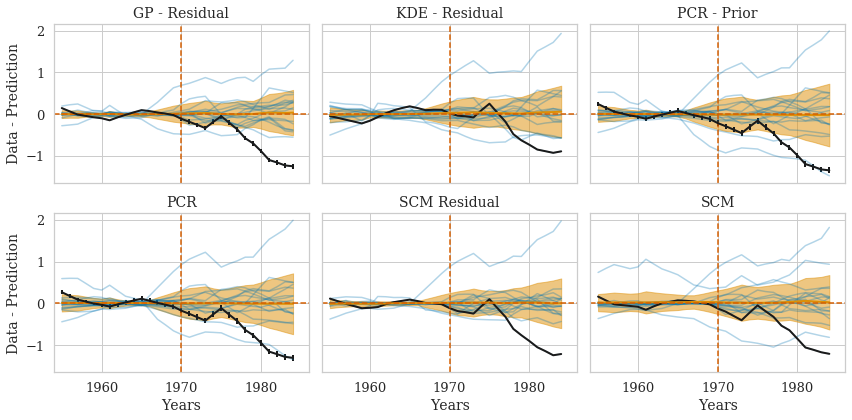

In [405]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

labels = ['SCM', 'SCM Residual', 'PCR',  'PCR - Prior', 'KDE - Residual',  'GP - Residual'][::-1]
ppp = 95
# kkeys = 'scmfits, scmfitsres, pcafits95, pcafitsyj95, kdefitsres, gpfitsres'
# kkeys = 'scmfits, scmfitsres, pcafits99, pcafitsyj99, kdefitsres, gpfitsres'
if ppp == 99:  kkeys = 'scmfits, scmfitsres, pcafits99regnoisepca, pcafitsyj99noisepca, kdefitsres, gpfitspca99res'
elif ppp == 95: kkeys = 'scmfits, scmfitsres, pcafits95regnoisepca, pcafitsyj95noisepca, kdefitsres, gpfitspca95res'
kkeys = kkeys.split(', ')[::-1]

i = 1

for ik, kk in enumerate(kkeys):
    
    axis = ax.flatten()[ik]
    dd =  basque[kk]
    xx = yyears[i]
    diff = dd[:, 0] - dd[:, 1]
    axis.plot(xx, diff.T, 'C0', alpha=0.3)

    try: axis.errorbar(xx, diff[itt[i]], dd[itt[i]][2], color= 'k', lw=2)
    except:     axis.plot(xx, diff[itt[i]], 'k', lw=2)

    mmean, sstd = diff.mean(axis=0), diff.std(axis=0)
    axis.plot(xx, mmean, 'C1', lw=2)
    axis.fill_between(xx, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(labels[ik], fontsize=fsize)
    axis.axhline(0, color='r', ls="--")
    axis.axvline(ivt[i], color='r', ls="--")
    axis.set_xlim(1954, 1986)
    
for axis in ax.flatten() : axis.tick_params(labelsize=fsize-1, rotation=0)
for axis in ax[1]:axis.set_xlabel('Years', fontsize=fsize)
for axis in ax[:, 0]:axis.set_ylabel('Data - Prediction', fontsize=fsize)
plt.tight_layout()
# if ppp == 99:
#     plt.savefig('../new_figs/basque_all99.png')    
#     plt.savefig('../new_figs/basque_all99.pdf')    
# elif ppp == 95:
#     plt.savefig('../new_figs/basque_all95.png')    
#     plt.savefig('../new_figs/basque_all95.pdf')    

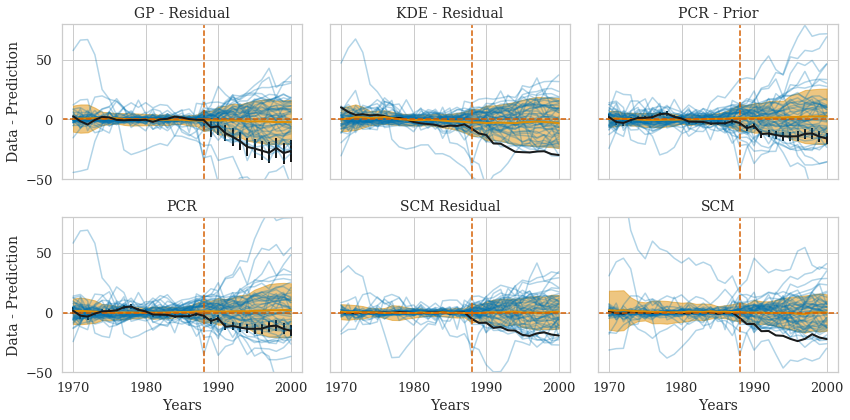

In [403]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

ppp = 95

labels = ['SCM', 'SCM Residual', 'PCR',  'PCR - Prior', 'KDE - Residual',  'GP - Residual'][::-1]
# kkeys = 'scmfits, scmfitsres, pcafits95, pcafitsyj95, kdefitsres, gpfitsres'
# kkeys = 'scmfits, scmfitsres, pcafits99, pcafitsyj99, kdefitsres, gpfitsres'
if ppp == 99:  kkeys = 'scmfits, scmfitsres, pcafits99regnoisepca, pcafitsyj99noisepca, kdefitsres, gpfitspca99res'
elif ppp == 95: kkeys = 'scmfits, scmfitsres, pcafits95regnoisepca, pcafitsyj95noisepca, kdefitsres, gpfitspca95res'
kkeys = kkeys.split(', ')[::-1]

i = 0

for ik, kk in enumerate(kkeys):
    
    axis = ax.flatten()[ik]
    dd =  ttax2000[kk]
    xx = yyears[i]
    diff = dd[:, 0] - dd[:, 1]
    axis.plot(xx, diff.T, 'C0', alpha=0.3)

    try: axis.errorbar(xx, diff[itt[i]], dd[itt[i]][2], color= 'k', lw=2)
    except:     axis.plot(xx, diff[itt[i]], 'k', lw=2)

    mmean, sstd = diff.mean(axis=0), diff.std(axis=0)
    axis.plot(xx, mmean, 'C1', lw=2)
    axis.fill_between(xx, mmean - sstd, mmean + sstd, alpha=0.5, color='C1')
    axis.set_title(labels[ik], fontsize=fsize)
    axis.axhline(0, color='r', ls="--")
    axis.axvline(ivt[i], color='r', ls="--")
    axis.set_ylim(-50, 80)

for axis in ax.flatten() : axis.tick_params(labelsize=fsize-1, rotation=0)
for axis in ax[1]:axis.set_xlabel('Years', fontsize=fsize)
for axis in ax[:, 0]:axis.set_ylabel('Data - Prediction', fontsize=fsize)
plt.tight_layout()
# if ppp == 99:
#     plt.savefig('../new_figs/ca_all99.png')    
#     plt.savefig('../new_figs/ca_all99.pdf')    
# elif ppp == 95:
#     plt.savefig('../new_figs/ca_all95.png')    
#     plt.savefig('../new_figs/ca_all95.pdf')    

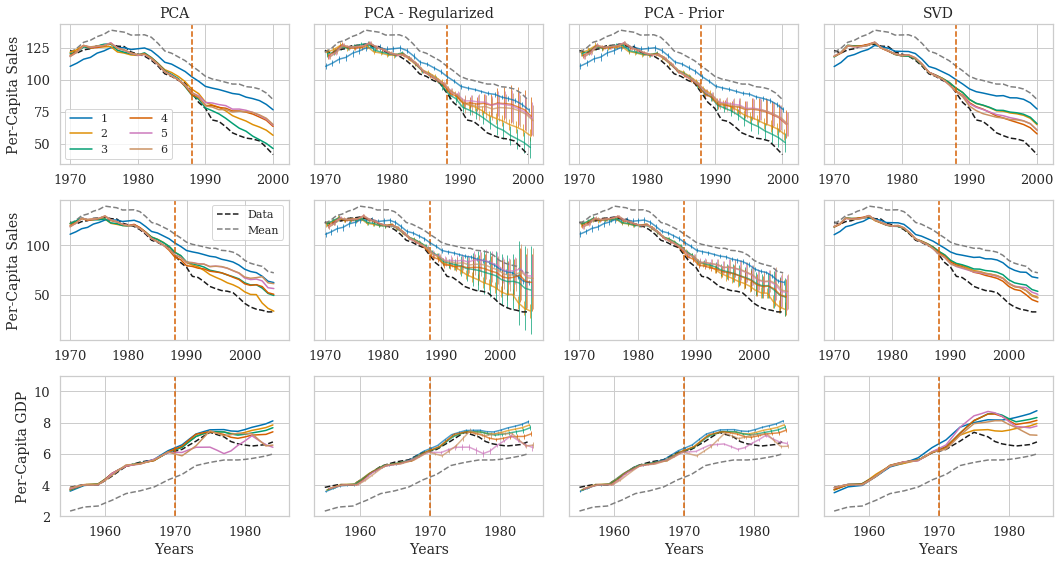

In [384]:
fig, ax = plt.subplots(3, 4, figsize=(15, 8), sharex='row', sharey='row')
fsize = 14
labels = ['PCA', 'PCA - Regularized', 'PCA - Prior',  'SVD']
# kkeys = 'pcapreds, pcapredsregnoise, pcapredsyjnoise, svdpreds'
kkeys = 'pcapreds, pcapredsregnoisepca, pcapredsyjnoisepca, svdpreds'
# kkeys = 'pcapreds, pcapredsreg, pcapredsyj, svdpreds'
kkeys = kkeys.split(', ')

i = 0

for i in range(3):
    for ik, kk in enumerate(kkeys):
        axis = ax[i, ik]
        if i == 1: axis = ax[2, ik]
        if i == 2: axis = ax[1, ik]
        dd =  dds[i][kk]
        mm = np.concatenate([dds[i]['scmfits'][:itt[i]], dds[i]['scmfits'][itt[i]+1:]]).mean(axis=0)[0]
        xx = yyears[i]
        lbl = None
        if i == 2 and ik==0: lbl = "Data"
        axis.plot(xx, dd[0, 0], 'k', ls="--", label=lbl)
        if i == 2 and ik == 0: lbl = "Mean"
        axis.plot(xx, mm, 'gray', ls="--", label=lbl)
        lbl = None
        for ncomp in range(1, 7):
            if (i == 0) & (ik == 0) : lbl = ncomp
            try: axis.errorbar(xx+ncomp*0.13, dd[ncomp-1, 1], dd[ncomp-1, 2], label=lbl, elinewidth=1, alpha=0.7)
            except Exception as e:
                axis.plot(xx, dd[ncomp-1, 1], label=lbl)

        if i == 0 : axis.set_title(labels[ik], fontsize=fsize)
        axis.axvline(ivt[i], color='r', ls="--")

#     try: axis.errorbar(xx, diff[itt[i]], dd[itt[i]][2], color= 'k', lw=2)
#     except:     axis.plot(xx, diff[itt[i]], 'k', lw=2)
#     axis.set_ylim(-50, 80)

for axis in ax.flatten() : axis.tick_params(labelsize=fsize-1, rotation=0)
for axis in ax[-1]:axis.set_xlabel('Years', fontsize=fsize)
# for axis in ax.flatten(): axis.legend(ncol=2)
ax[1, 0].legend(ncol=1)
ax[0, 0].legend(ncol=2)
ax[-1, 0].set_ylim(2, 11)
ax[0, 0].set_ylabel('Per-Capita Sales', fontsize=fsize)
ax[1, 0].set_ylabel('Per-Capita Sales', fontsize=fsize)
ax[2, 0].set_ylabel('Per-Capita GDP', fontsize=fsize)
# for axis in ax[:, 0]:axis.set_ylabel('Data - Prediction', fontsize=fsize)
plt.tight_layout()
# plt.savefig('../new_figs/pca.png')    
# plt.savefig('../new_figs/pca.pdf')    
# plt.savefig('../new_figs/pcanoise.png')    
# plt.savefig('../new_figs/pcanoise.pdf')    
# plt.savefig('../new_figs/pcanoisepca.png')    
# plt.savefig('../new_figs/pcanoisepca.pdf')    

In [378]:
tmp = (controls - pca.inverse_transform(pca.transform(controls - controls.mean(axis=0))) - means)
tmp.std(), tmp.std(axis=0).std()


(0.2040456599303265, 0.07457432105798072)

In [ ]:
data2 = pd.read_csv('../The_Tax_Burden_on_Tobacco__1970-2017.csv')
data2 = data2[data2['Year'] <=2000]
sales = data2[data2['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']
statesid = data2['LocationAbbr'].unique()
statesales, statecosts = {}, {}
for ss in statesid:
    statesales[ss] = sales[sales['LocationAbbr'] == ss]['Data_Value'].values.astype('float64')
sskip = ['CA', 'MA', 'AZ', 'OR', 'FL', 'AL', "HI", 'MD', 'MI','NJ', 'NY', 'WA', 'DC']
taxstates = ['CA', 'MA', 'OR', 'FL', 'AZ']
controlstates = list(set(statesid) - set(sskip))
controls2 = np.array([statesales[ss] for ss in statesid if ss!= 'CA'])
#
data2 = pd.read_csv('../The_Tax_Burden_on_Tobacco__1970-2017.csv')
data2 = data2[data2['Year'] <=2005]
sales = data2[data2['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']
statesid = data2['LocationAbbr'].unique()
statesales, statecosts = {}, {}
for ss in statesid:
    statesales[ss] = sales[sales['LocationAbbr'] == ss]['Data_Value'].values.astype('float64')
sskip = ['CA', 'MA', 'AZ', 'OR', 'FL', 'AL', "HI", 'MD', 'MI','NJ', 'NY', 'WA', 'DC']
taxstates = ['CA', 'MA', 'OR', 'FL', 'AZ']
controlstates = list(set(statesid) - set(sskip))
controls3 = np.array([statesales[ss] for ss in statesid if ss!= 'CA'])


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

ax[0].plot(np.linalg.svd(controls2)[1], marker='o', label='Raw Data')
ax[0].plot(np.linalg.svd(controls2 - controls2.mean(axis=0))[1], marker='x', label='Remove mean', markersize=9)
# ax[2].plot(np.linalg.svd(controls3)[1], marker='o', label='Raw Data')
# ax[2].plot(np.linalg.svd(controls - controls2.mean(axis=0))[1], marker='x', label='Remove mean', markersize=9)

ax[1].plot(np.linalg.svd(controls)[1], marker='o')
ax[1].plot(np.linalg.svd(controls - controls.mean(axis=0))[1], marker='x', markersize=9)
ax[0].set_ylim(10, 6000)
ax[1].set_ylim(0.1, 200)
ax[0].set_title('CA Prop 99 data', fontsize=fsize)
ax[1].set_title('Basque Country data', fontsize=fsize)
ax[0].legend(fontsize=fsize-2)
for axis in ax: 
    axis.set_yscale('log')
    axis.set_xlabel('Rank Singular Values', fontsize=fsize)
    axis.tick_params(labelsize=fsize-1)
plt.tight_layout()
# plt.savefig('../new_figs/svalues.png')
# plt.savefig('../new_figs/svalues.pdf')

In [ ]:
tools.approximate_rank(controls2 - controls2.mean(axis=0), 0.95)

In [ ]:
pcafits99[1].pcl.pca